## Notebook for preliminary data analysis that would eventually migrate to interareal_plotting.ipynb

In [91]:
%run ./rob_setup_notebook.ipynb

import utils.interareal_analysis as ia
import utils.interareal_plotting as ip
import utils.utils_funcs as uf
import utils.gsheets_importer as gsi
from ia_funcs import *
from utils.paq2py import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Suite2p path: ['/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/suite2p']
QNAP_path: /home/rlees/mnt/qnap 
QNAP_data_path /home/rlees/mnt/qnap/Data 
Pickle folder: /home/rlees/mnt/qnap/pkl_files 
Master pickle: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
Figure save path: /home/rlees/mnt/qnap/Analysis/Figures 
STA movie save path: /home/rlees/mnt/qnap/Analysis/STA_movies 
S2 borders path: /home/rlees/mnt/qnap/Analysis/S2_borders


# Data organisation

### For the following dataframes it will be possible to uses the dataframe above to index the dataframe below, or vice versa

## [Session] dataframe
- all sessions in project (index = project x session)
- include information such as:
    - ss_id [string]
    - session_id [string] (sheet_name)
    - s2p_path [string]
    - frame_list [string]
    - x_pix_reg [list] (xoff)
    - y_pix_reg [list] (yoff)
    - mean_img [array]
    - mean_imgE [array]

## [Session x Experiment] dataframe
- all experiments i.e. stim types across all sessions (index = session x experiment)
- include information such as:
    - session_id (sheet_name)
    - stim_type
    - tiff_path
    - naparm_path
    - paq_path
    - stim_channel
    - fps
    - frame_x
    - frame_y
    - n_planes
    - pix_sz_x
    - pix_sz_y
    - scan_x
    - scan_y
    - zoom
    - n_frames
    - last_good_frame
    - n_groups
    - n_reps
    - n_shots
    - inter_point_delay
    - single_stim_dur
    - spiral_size
    - stim_dur
    - stim_freq
    - duration_frames
    - frames [tuple]
    - n_units
    - num_s1_cells
    - num_s2_cells
    - pre_frames
    - post_frames
    - test_frames
    - n_trials
    - n_targets
    - n_targeted_cells
    - sta_euclid_dist

## [Session x Trial] dataframe
- all trials across all experiments i.e. stim types for all sessions (index = session x experiment x trial)
    - session_id (sheet_name)
    - stim_type
    - trial_num [float]
    - trial_target_dff
    - trial_target_euclid_dist
    
## [Session x Cell] dataframe
- all cells across all sessions (index = session x cell)
- include information such as:
    - session_id (sheet_name)
    - cell_id [float]
    - s1_cell [bool]
    - s2_cell [bool]
    - pr_target [bool]
    - ps_target [bool]
    - pr_resp_sign [string]
    - ps_resp_sign [string]
    - spont_resp_sign [string]
    - whisker_resp_sign [string]
    - cell_med [tuple]
    - cell_x [list]
    - cell_y [list]
    - prob_response_pr [float]
    - prob_response_ps [float]
    - prob_response_whisker [float]
    - prob_response_spont
    - sta_sig_pr [bool]
    - sta_sig_ps [bool]
    - sta_sig_whisker [bool]
    - sta_sig_spont [bool]
    - sta_sig_nomulti_pr [bool]
    - sta_sig_nomulti_ps [bool]
    - sta_sig_nomulti_whisker [bool]
    - sta_sig_nomulti_spont [bool]

## [Session x Cell x Trial] dataframe
- all trials across all cells for all sessions (index = session x cell x trial)
- include information such as:
    - session_id (sheet_name)
    - cell_id
    - trial_num [float]
    - wilcoxons
    - trial_sig_dff [bool]
    - trial_sig_dfsf [bool]

## [Session x Cell x Mean Timepoint] dataframe
- all timepoints across all cells for all trial averages i.e. sessions (index = session x cell x timepoint)
- include information such as:
    - session_id (sheet_name)
    - cell_id [float]
    - timepoint [timepoints] (a.k.a. time)
    - pr_sta_resp [dff]
    - ps_sta_resp [dff]
    - w_sta_resp [dff]
    - spont_sta_resp [dff]
    - pr_sta_amp_resp
    - ps_sta_amp_resp
    - w_sta_amp_resp
    - spont_sta_amp_resp
    
## [Session x Cell x Trial x Single Timepoint] dataframe
- all timepoints across all cells for all trials (index = session x cell x trial x timepoint)
- include information such as:
    - session_id (sheet_name)
    - cell_id [float]
    - trial_num [float]
    - timepoint [timepoints] (a.k.a. time)
    - pr_resp [dff]
    - ps_resp [dff]
    - w_resp [dff]
    - spont_resp [dff]
    - pr_amp_resp
    - ps_amp_resp
    - w_amp_resp
    - spont_amp_resp
    
# Use cases:
- find average response to pr stim in ps targets
    - use the cell dataframe to get cell IDs for ps targets and index the timepoint dataframe to produce an average response to pr
- find sum or mean dff response on a single trial for pr target cells
    - use the cell dataframe to find pr target cells, use timepoint dataframe to group by trial_num and mean the pre and post

### Construct dataframes

In [122]:
df_name = 'session_df'
stim_types = ['pr', 'ps', 'none', 'w']
pkl_files = listdirFullpath(pkl_folder, string='.pkl')

df = pd.DataFrame()

for pkl in pkl_files:
        
    ses_obj = loadPickle(pkl)
    
    ss_id = ses_obj.ss_id
    session_id = ses_obj.sheet_name
    s2p_path = ses_obj.s2p_path
    frame_list = list(ses_obj.frame_list)
    
    exp_list = makeExpList(ses_obj, stim_types)

    x_pix_reg = list(exp_list[0].xoff)
    y_pix_reg = list(exp_list[0].yoff)
    mean_img = exp_list[0].mean_img[0]
    mean_imgE = exp_list[0].mean_imgE[0]
            
    temp_df = pd.DataFrame({'ss_id'      : ss_id,
                            'session_id' : session_id,
                            's2p_path'   : s2p_path,
                            'frame_list' : [frame_list],
                            'x_pix_reg'  : [x_pix_reg],
                            'y_pix_reg'  : [y_pix_reg],
                            'mean_img'   : [mean_img],
                            'mean_imgE'  : [mean_imgE]
                            })
    df = pd.concat([df, temp_df])
    
# Pickle the object output to save it for analysis
pkl_path = os.path.join(pkl_folder, 'dataframes', df_name + '.pkl')

with open(pkl_path, 'wb') as f:
    pickle.dump(df, f)  

Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J061.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J063.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-15_J064.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-18_J065.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-02-27_RL075.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-03_RL074.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-05_RL070.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-05_RL072.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-04_RL093.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-08_RL099.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-09_RL100.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-14_RL101.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-15_RL102.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-16_RL103.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-

In [123]:
df

,ss_id,session_id,s2p_path,frame_list,x_pix_reg,y_pix_reg,mean_img,mean_imgE
0,1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY,2019-11-14_J061,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,"[22282, 20251, 22545, 22986]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1.945594101123595, 1.8409073033707855, 2.141...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY,2019-11-14_J063,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,"[22986, 22986, 22124, 22986]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[5.2701277836691425, 2.7183388123011665, 3.11...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY,2019-11-15_J064,/home/rlees/mnt/qnap/Data/2019-11-15/2019-11-1...,"[22986, 22986, 22986, 22986]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0...","[[7.494331890198968, 6.7793953574060435, 6.420...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY,2019-11-18_J065,/home/rlees/mnt/qnap/Data/2019-11-18/2019-11-1...,"[22986, 22986, 22986, 22986]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[[10.816822126013262, 14.084525239498898, 17.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY,2020-02-27_RL075,/home/rlees/mnt/qnap/Data/2020-02-27/2020-02-2...,"[23437, 23437, 17427, 22535]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, -1....","[[5.224466754660947, 5.777920695154813, 6.1718...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY,2020-03-03_RL074,/home/rlees/mnt/qnap/Data/2020-03-03/RL074/202...,"[23437, 23437, 15288, 22535]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0...","[[10.937024913494808, 11.191718744197827, 11.7...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY,2020-03-05_RL070,/home/rlees/mnt/qnap/Data/2020-03-05/2020-03-0...,"[23437, 23437, 18028, 22535]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[5.3651707925941325, 5.6294458081963805, 5.65...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY,2020-03-05_RL072,/home/rlees/mnt/qnap/Data/2020-03-05/2020-03-0...,"[23437, 23437, 18028, 22535]","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[-1.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0, -...","[[6.367650301643439, 7.54992848970252, 7.93999...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY,2020-09-04_RL093,/home/rlees/mnt/qnap/Data/2020-09-04/RL093/202...,"[23437, 23437, 16977, 23437]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0...","[[4.425145517676769, 4.418683080808081, 4.3746...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,1PgSXs6BVHe9dACWEydykucN74rirNfOY4Vr_AmLcCdY,2020-09-08_RL099,/home/rlees/mnt/qnap/Data/2020-09-08/RL099/202...,"[22986, 22986, 16977, 22986]","[2.0, 3.0, 3.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, ...","[-1.0, 0.0, -1.0, -2.0, -2.0, -2.0, -2.0, -1.0...","[[7.415845106330063, 7.596521141649053, 7.2726...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [154]:
df_name = 'session_experiment_df'
stim_types = ['pr', 'ps', 'none', 'w']
pkl_files = listdirFullpath(pkl_folder, string='.pkl')

df = pd.DataFrame()

for pkl in pkl_files:
        
    ses_obj = loadPickle(pkl)
    
    exp_list = makeExpList(ses_obj, stim_types)
    
    for exp_obj in exp_list:
        
        session_id = exp_obj.sheet_name
        stim_type = exp_obj.stim_type
        tiff_path = str(exp_obj.tiff_path)
        naparm_path = str(exp_obj.naparm_path)
        paq_path = str(exp_obj.paq_path)
        stim_channel = exp_obj.stim_channel
        fps = exp_obj.fps
        frame_x = exp_obj.frame_x
        frame_y = exp_obj.frame_y
        n_planes = exp_obj.n_planes
        pix_sz_x = exp_obj.pix_sz_x
        pix_sz_y = exp_obj.pix_sz_y
        scan_x = exp_obj.scan_x
        scan_y = exp_obj.scan_y
        zoom = exp_obj.zoom
        n_frames = int(exp_obj.n_frames)
        last_good_frame = int(exp_obj.last_good_frame)
        stim_dur = exp_obj.stim_dur
        stim_freq = exp_obj.stim_freq
        duration_frames = exp_obj.duration_frames
        frames = exp_obj.frames
        n_units = exp_obj.n_units[0]
        num_s1_cells = exp_obj.num_s1_cells[0]
        num_s2_cells = exp_obj.num_s2_cells[0]
        pre_frames = exp_obj.pre_frames
        post_frames = exp_obj.post_frames
        test_frames = exp_obj.test_frames
        pre_trial_frames = exp_obj.pre_trial_frames
        post_trial_frames = exp_obj.post_trial_frames
        n_trials = exp_obj.n_trials
        
        try:
            n_groups = exp_obj.n_groups
            n_reps = exp_obj.n_reps
            n_shots = exp_obj.n_shots
            inter_point_delay = exp_obj.inter_point_delay
            single_stim_dur = exp_obj.single_stim_dur
            spiral_size = exp_obj.spiral_size
            n_targets = exp_obj.n_targets
            n_targeted_cells = int(exp_obj.n_targeted_cells)
            sta_euclid_dist = exp_obj.sta_euclid_dist
        except AttributeError:
            print('no photostim attributes for this experiment')
            n_groups = np.nan
            n_reps = np.nan
            n_shots = np.nan
            inter_point_delay = np.nan
            single_stim_dur = np.nan
            spiral_size = np.nan
            n_targets = np.nan
            n_targeted_cells = np.nan
            sta_euclid_dist = np.nan
        
        temp_df = pd.DataFrame({'session_id' : session_id,
                                'stim_type'  : stim_type,
                                'tiff_path' : tiff_path,
                                'naparm_path' : naparm_path,
                                'paq_path' : paq_path,
                                'stim_channel' : stim_channel,
                                'fps' : fps,
                                'frame_x' : frame_x,
                                'frame_y' : frame_y,
                                'n_planes' : n_planes,
                                'pix_sz_x' : pix_sz_x,
                                'pix_sz_y' : pix_sz_y,
                                'scan_x' : scan_x,
                                'scan_y' : scan_y,
                                'zoom' : zoom,
                                'n_frames' : n_frames,
                                'last_good_frame' : last_good_frame,
                                'stim_dur' : stim_dur,
                                'stim_freq' : stim_freq,
                                'duration_frames' : duration_frames,
                                'frames' : [frames],
                                'n_units' : n_units,
                                'num_s1_cells' : num_s1_cells,
                                'num_s2_cells' : num_s2_cells,
                                'pre_frames' : pre_frames,
                                'post_frames' : post_frames,
                                'test_frames' : test_frames,
                                'pre_trial_frames' : pre_trial_frames,
                                'post_trial_frames' : post_trial_frames,
                                'n_trials' : n_trials,
                                'sta_euclid_dist' : sta_euclid_dist,
                                'n_groups' : n_groups,
                                'n_reps' : n_reps,
                                'n_shots' : n_shots,
                                'inter_point_delay' : inter_point_delay,
                                'single_stim_dur' : single_stim_dur,
                                'spiral_size' : spiral_size,
                                'n_targets' : n_targets,
                                'n_targeted_cells' : n_targeted_cells
                                })
        
        df = pd.concat([df, temp_df])
    
# Pickle the object output to save it for analysis
pkl_path = os.path.join(pkl_folder, 'dataframes', df_name + '.pkl')

with open(pkl_path, 'wb') as f:
    pickle.dump(df, f)  

Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J061.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J063.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-15_J064.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-18_J065.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-02-27_RL075.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-03_RL074.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-05_RL070.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-05_RL072.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-04_RL093.pkl
no photostim attributes for this experim

In [155]:
df

,session_id,stim_type,tiff_path,naparm_path,paq_path,stim_channel,fps,frame_x,frame_y,n_planes,...,n_trials,sta_euclid_dist,n_groups,n_reps,n_shots,inter_point_delay,single_stim_dur,spiral_size,n_targets,n_targeted_cells
0,2019-11-14_J061,pr,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,markpoints2packio,15.023206,1024,1024,1,...,98,152.797506,3.0,8.0,1.0,5.0,10.0,10.0,26.0,61.0
0,2019-11-14_J061,ps,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,markpoints2packio,15.023206,1024,1024,1,...,89,135.000138,3.0,8.0,1.0,5.0,10.0,10.0,26.0,65.0
0,2019-11-14_J061,none,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,none,markpoints2packio,15.023206,1024,1024,1,...,100,NaN,3.0,8.0,1.0,5.0,10.0,10.0,26.0,61.0
0,2019-11-14_J061,w,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,none,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,piezo_stim,15.023207,1024,1024,1,...,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2019-11-14_J063,pr,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,/home/rlees/mnt/qnap/Data/2019-11-14/2019-11-1...,markpoints2packio,15.023207,1024,1024,1,...,100,161.103100,3.0,8.0,1.0,5.0,10.0,10.0,26.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2020-10-02_RL108,w,/home/rlees/mnt/qnap/Data/2020-10-02/RL108/202...,none,/home/rlees/mnt/qnap/Data/2020-10-02/RL108/202...,piezo_stim,15.023206,1024,1024,1,...,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2020-10-12_RL109,pr,/home/rlees/mnt/qnap/Data/2020-10-12/RL109/202...,/home/rlees/mnt/qnap/Data/2020-10-12/RL109/202...,/home/rlees/mnt/qnap/Data/2020-10-12/RL109/202...,markpoints2packio,15.023206,1024,1024,1,...,100,156.045176,2.0,10.0,1.0,5.0,10.0,10.0,33.0,88.0
0,2020-10-12_RL109,ps,/home/rlees/mnt/qnap/Data/2020-10-12/RL109/202...,/home/rlees/mnt/qnap/Data/2020-10-12/RL109/202...,/home/rlees/mnt/qnap/Data/2020-10-12/RL109/202...,markpoints2packio,15.023207,1024,1024,1,...,100,161.351866,2.0,10.0,1.0,5.0,10.0,10.0,34.0,94.0
0,2020-10-12_RL109,none,/home/rlees/mnt/qnap/Data/2020-10-12/RL109/202...,/home/rlees/mnt/qnap/Data/2020-10-12/RL109/202...,/home/rlees/mnt/qnap/Data/2020-10-12/RL109/202...,markpoints2packio,15.023206,1024,1024,1,...,100,NaN,2.0,10.0,1.0,5.0,10.0,10.0,33.0,88.0


In [182]:
df_name = 'session_trial_df'
stim_types = ['pr', 'ps', 'none', 'w']
pkl_files = listdirFullpath(pkl_folder, string='.pkl')

df = pd.DataFrame()

for pkl in pkl_files:
        
    ses_obj = loadPickle(pkl)
    
    exp_list = makeExpList(ses_obj, stim_types)
    
    for exp_obj in exp_list:
        
        session_id = list(np.repeat(exp_obj.sheet_name, exp_obj.n_trials))
        stim_type = list(np.repeat(exp_obj.stim_type, exp_obj.n_trials))
        trial_num = list(range(1,exp_obj.n_trials+1))
        try:
            trial_target_dff = exp_obj.trial_target_dff
            trial_target_euclid_dist = exp_obj.trial_euclid_dist
        except AttributeError:
            print('no photostim attributes for this experiment')
            trial_target_dff = list(np.repeat(np.nan, exp_obj.n_trials))
            trial_target_euclid_dist = list(np.repeat(np.nan, exp_obj.n_trials))
        
        temp_df = pd.DataFrame({'session_id' : session_id,
                                'stim_type'  : stim_type,
                                'trial_num'  : trial_num,
                                'trial_target_dff' : trial_target_dff,
                                'trial_target_euclid_dist' : trial_target_euclid_dist
                                })
        
        df = pd.concat([df, temp_df])
    
# Pickle the object output to save it for analysis
pkl_path = os.path.join(pkl_folder, 'dataframes', df_name + '.pkl')

with open(pkl_path, 'wb') as f:
    pickle.dump(df, f)  

Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J061.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J063.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-15_J064.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-18_J065.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-02-27_RL075.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-03_RL074.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-05_RL070.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-05_RL072.pkl
no photostim attributes for this experiment
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-04_RL093.pkl
no photostim attributes for this experim

In [183]:
df

,session_id,stim_type,trial_num,trial_target_dff,trial_target_euclid_dist
0,2019-11-14_J061,pr,1,59.846809,150.940670
1,2019-11-14_J061,pr,2,36.655338,137.578780
2,2019-11-14_J061,pr,3,31.760790,149.769596
3,2019-11-14_J061,pr,4,26.813622,150.004456
4,2019-11-14_J061,pr,5,25.893536,150.000944
...,...,...,...,...,...
95,2020-10-12_RL109,w,96,NaN,NaN
96,2020-10-12_RL109,w,97,NaN,NaN
97,2020-10-12_RL109,w,98,NaN,NaN
98,2020-10-12_RL109,w,99,NaN,NaN


In [69]:
df_name = 'session_cell_df'
stim_types = ['pr', 'ps', 'none', 'w']
pkl_files = listdirFullpath(pkl_folder, string='.pkl')

df = pd.DataFrame()

for pkl in pkl_files:
        
    ses_obj = loadPickle(pkl)
    
    exp_list = makeExpList(ses_obj, stim_types)
    
    session_id = list(np.repeat(exp_list[0].sheet_name, exp_list[0].n_units[0]))
    cell_id = exp_list[0].cell_id[0]
    s1_cell = exp_list[0].cell_s1[0]
    s2_cell = exp_list[0].cell_s2[0]
    cell_med = exp_list[0].cell_med[0]
    cell_x = exp_list[0].cell_x[0]
    cell_y = exp_list[0].cell_y[0]
    
    for exp_obj in exp_list:
        
        if exp_obj.stim_type == 'pr':
            pr_target = exp_obj.targeted_cells
            pr_resp_pos = exp_obj.sta_amplitudes[0] > 0
            prob_response_pr = exp_obj.prob_response[0]
            sta_sig_pr = exp_obj.sta_sig[0]
            sta_sig_nomulti_pr = exp_obj.sta_sig_nomulti[0]
            wilcoxons_pr = exp_obj.wilcoxons[0]
        
        if exp_obj.stim_type == 'ps':
            ps_target = exp_obj.targeted_cells
            ps_resp_pos = exp_obj.sta_amplitudes[0] > 0
            prob_response_ps = exp_obj.prob_response[0]
            sta_sig_ps = exp_obj.sta_sig[0]
            sta_sig_nomulti_ps = exp_obj.sta_sig_nomulti[0]
            wilcoxons_ps = exp_obj.wilcoxons[0]
        
        if exp_obj.stim_type == 'none':
            spont_resp_pos = exp_obj.sta_amplitudes[0] > 0
            prob_response_spont = exp_obj.prob_response[0]
            sta_sig_spont = exp_obj.sta_sig[0]
            sta_sig_nomulti_spont = exp_obj.sta_sig_nomulti[0]
            wilcoxons_spont = exp_obj.wilcoxons[0]
        
        if exp_obj.stim_type == 'w':
            whisker_resp_pos = exp_obj.sta_amplitudes[0] > 0
            prob_response_whisker = exp_obj.prob_response[0]
            sta_sig_whisker = exp_obj.sta_sig[0]
            sta_sig_nomulti_whisker = exp_obj.sta_sig_nomulti[0]
            wilcoxons_whisker = exp_obj.wilcoxons[0]
        
    temp_df = pd.DataFrame({'session_id' : session_id,
                            'cell_id' : cell_id,
                            's1_cell' : s1_cell,
                            's2_cell' : s2_cell,
                            'cell_med' : cell_med,
                            'cell_x' : cell_x,
                            'cell_y' : cell_y,
                            'pr_target' : pr_target,
                            'ps_target' : ps_target,
                            'pr_resp_pos' : pr_resp_pos,
                            'ps_resp_pos' : ps_resp_pos,
                            'spont_resp_pos' : spont_resp_pos,
                            'whisker_resp_pos' : whisker_resp_pos,
                            'prob_response_pr' : prob_response_pr,
                            'prob_response_ps' : prob_response_ps,
                            'prob_response_spont' : prob_response_spont,
                            'prob_response_whisker' : prob_response_whisker,
                            'sta_sig_pr' : sta_sig_pr,
                            'sta_sig_ps' : sta_sig_ps,
                            'sta_sig_spont' : sta_sig_spont,
                            'sta_sig_whisker' : sta_sig_whisker,
                            'sta_sig_nomulti_pr' : sta_sig_nomulti_pr,
                            'sta_sig_nomulti_ps' : sta_sig_nomulti_ps,
                            'sta_sig_nomulti_spont' : sta_sig_nomulti_spont,
                            'sta_sig_nomulti_whisker' : sta_sig_nomulti_whisker,
                            'wilcoxons_pr' : wilcoxons_pr,
                            'wilcoxons_ps' : wilcoxons_ps,
                            'wilcoxons_spont' : wilcoxons_spont,
                            'wilcoxons_whisker' : wilcoxons_whisker
                            })
        
    df = pd.concat([df, temp_df])
    
# Pickle the object output to save it for analysis
pkl_path = os.path.join(pkl_folder, 'dataframes', df_name + '.pkl')

with open(pkl_path, 'wb') as f:
    pickle.dump(df, f)  

Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J061.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J063.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-15_J064.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-18_J065.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-02-27_RL075.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-03_RL074.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-05_RL070.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-03-05_RL072.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-04_RL093.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-08_RL099.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-09_RL100.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-14_RL101.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-15_RL102.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-09-16_RL103.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2020-

In [70]:
df

,session_id,cell_id,s1_cell,s2_cell,cell_med,cell_x,cell_y,pr_target,ps_target,pr_resp_pos,...,sta_sig_spont,sta_sig_whisker,sta_sig_nomulti_pr,sta_sig_nomulti_ps,sta_sig_nomulti_spont,sta_sig_nomulti_whisker,wilcoxons_pr,wilcoxons_ps,wilcoxons_spont,wilcoxons_whisker
0,2019-11-14_J061,0,False,True,"[492.0, 802.0]","[799, 800, 801, 799, 800, 801, 802, 803, 799, ...","[487, 487, 487, 488, 488, 488, 488, 488, 489, ...",False,False,True,...,False,True,False,False,False,True,8.663316e-01,0.450340,0.844622,2.219249e-10
1,2019-11-14_J061,1,False,True,"[234.0, 903.0]","[903, 904, 905, 901, 902, 903, 904, 905, 906, ...","[229, 229, 229, 230, 230, 230, 230, 230, 230, ...",False,False,False,...,False,False,False,False,True,False,3.690274e-01,0.519328,0.046127,4.384317e-01
2,2019-11-14_J061,2,True,False,"[688.0, 168.0]","[165, 166, 167, 168, 169, 170, 163, 164, 165, ...","[685, 685, 685, 685, 685, 685, 686, 686, 686, ...",False,True,False,...,False,True,True,True,False,True,3.735604e-02,0.010371,0.728388,7.350292e-03
3,2019-11-14_J061,3,False,True,"[952.0, 665.0]","[667, 667, 664, 667, 668, 664, 665, 666, 667, ...","[943, 944, 945, 945, 945, 946, 946, 946, 946, ...",False,False,True,...,False,False,False,True,True,False,4.818065e-01,0.028459,0.003749,4.572203e-01
4,2019-11-14_J061,4,True,False,"[782.0, 138.0]","[136, 137, 138, 135, 136, 137, 138, 139, 134, ...","[777, 777, 777, 778, 778, 778, 778, 778, 779, ...",False,False,True,...,False,False,False,False,False,False,4.818065e-01,0.145818,0.239632,2.950595e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,2020-10-12_RL109,4370,True,False,"[593.0, 295.0]","[293, 291, 292, 293, 294, 290, 291, 292, 293, ...","[587, 588, 588, 588, 588, 589, 589, 589, 589, ...",False,False,False,...,False,False,False,False,False,True,1.788239e-01,0.382481,0.712947,3.535623e-02
2511,2020-10-12_RL109,4374,True,False,"[337.0, 622.0]","[621, 622, 623, 624, 619, 620, 621, 622, 623, ...","[332, 332, 332, 332, 333, 333, 333, 333, 333, ...",False,True,False,...,False,False,False,False,False,False,3.676728e-01,0.313729,0.947913,1.031510e-01
2512,2020-10-12_RL109,4378,True,False,"[595.0, 592.0]","[589, 590, 591, 589, 590, 591, 592, 593, 588, ...","[590, 590, 590, 591, 591, 591, 591, 591, 592, ...",False,False,True,...,False,False,True,True,False,False,4.260964e-11,0.036573,0.378745,6.598606e-01
2513,2020-10-12_RL109,4380,True,False,"[568.0, 73.0]","[72, 73, 75, 70, 71, 72, 73, 74, 75, 69, 70, 7...","[564, 564, 564, 565, 565, 565, 565, 565, 565, ...",False,False,True,...,False,False,False,False,False,False,6.190014e-02,0.313729,0.831190,5.775215e-01


In [ ]:
df_name = 'session_cell_trial_df'
stim_types = ['pr', 'ps', 'none', 'w']
pkl_files = listdirFullpath(pkl_folder, string='.pkl')

df = pd.DataFrame()

for pkl in pkl_files:
        
    ses_obj = loadPickle(pkl)
    
    exp_list = makeExpList(ses_obj, stim_types)
    
    session_id = list(np.repeat(exp_list[0].sheet_name, exp_list[0].n_units[0] * 100))
    cell_id = np.repeat(exp_list[0].cell_id[0], 100, axis=0)
    trial_num = np.repeat(np.arange(1,101), len(exp_list[0].cell_id[0]), axis=0)
    
    for exp_obj in exp_list:
        
        if exp_obj.stim_type == 'pr':
            trial_sig_dff_pr = pd.Series(exp_obj.trial_sig_dff[0].flatten()).reindex(np.arange(0,len(trial_num)))
            trial_sig_dfsf_pr = pd.Series(exp_obj.trial_sig_dfsf[0].flatten()).reindex(np.arange(0,len(trial_num)))
            
        if exp_obj.stim_type == 'ps':
            trial_sig_dff_ps = pd.Series(exp_obj.trial_sig_dff[0].flatten()).reindex(np.arange(0,len(trial_num)))
            trial_sig_dfsf_ps = pd.Series(exp_obj.trial_sig_dfsf[0].flatten()).reindex(np.arange(0,len(trial_num)))
                    
        if exp_obj.stim_type == 'none':
            trial_sig_dff_spont = pd.Series(exp_obj.trial_sig_dff[0].flatten()).reindex(np.arange(0,len(trial_num)))
            trial_sig_dfsf_spont = pd.Series(exp_obj.trial_sig_dfsf[0].flatten()).reindex(np.arange(0,len(trial_num)))
                    
        if exp_obj.stim_type == 'w':
            trial_sig_dff_whisker = pd.Series(exp_obj.trial_sig_dff[0].flatten()).reindex(np.arange(0,len(trial_num)))
            trial_sig_dfsf_whisker = pd.Series(exp_obj.trial_sig_dfsf[0].flatten()).reindex(np.arange(0,len(trial_num)))
                    
    temp_df = pd.DataFrame({'session_id' : session_id,
                            'cell_id' : cell_id,
                            'trial_num' : trial_num,
                            'trial_sig_dff_pr' : trial_sig_dff_pr,
                            'trial_sig_dfsf_pr' : trial_sig_dfsf_pr,
                            'trial_sig_dff_ps' : trial_sig_dff_ps,
                            'trial_sig_dfsf_ps' : trial_sig_dfsf_ps,
                            'trial_sig_dff_spont' : trial_sig_dff_spont,
                            'trial_sig_dfsf_spont' : trial_sig_dfsf_spont,
                            'trial_sig_dff_whisker' : trial_sig_dff_whisker,
                            'trial_sig_dfsf_whisker' : trial_sig_dfsf_whisker,
                            })
        
    df = pd.concat([df, temp_df])
    
# Pickle the object output to save it for analysis
pkl_path = os.path.join(pkl_folder, 'dataframes', df_name + '.pkl')

with open(pkl_path, 'wb') as f:
    pickle.dump(df, f)

Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J061.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J063.pkl
Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-15_J064.pkl


In [ ]:
df

### Add or check attributes in all session objects

In [ ]:
sheet_names = ['2019-06-11_J048',
                '2019-06-13_J052',
                '2019-06-25_RL048',
                '2019-07-15_RL052',
                '2019-08-14_J058',
                '2019-08-14_J059',
                '2019-08-15_RL055',
                '2019-11-14_J061',
                '2019-11-14_J063',
                '2019-11-15_J064',
                '2019-11-18_J065',
                '2020-02-27_RL075',
                '2020-03-03_RL074',
                '2020-03-05_RL070',
                '2020-03-05_RL072']

s1s2_coords = [[294, 119, 750, 166],
                [213, 165, 735, 234],
                [148, 203, 760, 175],
                [177, 332, 825, 404],
                [291, 183, 715, 345],
                [148, 114, 764, 203],
                [132, 273, 659, 328],
                [341, 453, 700, 535],
                [264, 481, 657, 605],
                [412, 440, 703, 580],
                [304, 515, 637, 625],
                [239, 452, 571, 456],
                [244, 453, 743, 567],
                [269, 429, 843, 520],
                [327, 519, 807, 607]]

# # To add s1/s2 coords to pickled objects
# for sheet_name, [s1_x, s1_y, s2_x, s2_y] in zip(sheet_names, s1s2_coords):
#     if sheet_name in pkl:
#         ses_obj.s1_coord = [s1_x, s1_y]
#         ses_obj.s2_coord = [s2_x, s2_y]

In [ ]:
pkl_files = [p for p in os.listdir(pkl_folder) if '.pkl' in p]
pkl_files.sort()

for pkl in pkl_files:
        
    print(pkl)

    pkl_path = os.path.join(pkl_folder, pkl)

    with open(pkl_path, 'rb') as f:
        ses_obj = pickle.load(f)

    exp_list = [ses_obj.photostim_r, ses_obj.photostim_s]

    if ses_obj.spont.n_frames > 0:
        exp_list.append(ses_obj.spont)

    if ses_obj.whisker_stim.n_frames > 0:
        exp_list.append(ses_obj.whisker_stim)

    for exp_obj in exp_list:
        
#     with open(pkl_path, 'wb') as f:
#         pickle.dump(ses_obj, f)

### Responding cells after FDR correction adjustments

In [120]:
pkl_files = [p for p in os.listdir(pkl_folder) if '.pkl' in p]
pkl_files.sort()

pr_s1_all = []
pr_s2_all = []
pr_s1_notarget = []
pr_s2_notarget = []

ps_s1_all = []
ps_s2_all = []
ps_s1_notarget = []
ps_s2_notarget = []

for pkl in pkl_files:
        
    print(pkl)

    pkl_path = os.path.join(pkl_folder, pkl)

    with open(pkl_path, 'rb') as f:
        ses_obj = pickle.load(f)

#     with open(pkl_path, 'wb') as f:
#         pickle.dump(ses_obj, f)

    exp_list = [ses_obj.photostim_r, ses_obj.photostim_s]

    if ses_obj.spont.n_frames > 0:
        exp_list.append(ses_obj.spont)

    if ses_obj.whisker_stim.n_frames > 0:
        exp_list.append(ses_obj.whisker_stim)

    for exp_obj in exp_list:
        
        targets = exp_obj.targeted_cells
        s1_cells = np.array(exp_obj.cell_s1[0])[~targets]
        s2_cells = np.array(exp_obj.cell_s2[0])[~targets]
        
        nontarget_p_vals = exp_obj.wilcoxons[0][~targets]
        
        s1_p = nontarget_p_vals[s1_cells]
        s2_p = nontarget_p_vals[s2_cells]
        target_p = exp_obj.wilcoxons[0][targets]

        alpha = 0.1 

        s1_sig, _, _, _ = smstats.multitest.multipletests(s1_p, alpha=alpha, method='fdr_bh', 
                                                                         is_sorted=False, returnsorted=False)
        s2_sig, _, _, _ = smstats.multitest.multipletests(s2_p, alpha=alpha, method='fdr_bh', 
                                                                         is_sorted=False, returnsorted=False)
        target_sig, _, _, _ = smstats.multitest.multipletests(target_p, alpha=alpha, method='fdr_bh', 
                                                                         is_sorted=False, returnsorted=False)
        
        if exp_obj.stim_type == 'pr':
            pr_s1_all.append(np.sum(exp_obj.sta_sig[0][exp_obj.cell_s1[0]&~targets]))
            pr_s2_all.append(np.sum(exp_obj.sta_sig[0][exp_obj.cell_s2[0]&~targets]))
            
            pr_s1_notarget.append(np.sum(s1_sig))
            pr_s2_notarget.append(np.sum(s2_sig))
            
        if exp_obj.stim_type == 'ps':
            ps_s1_all.append(np.sum(exp_obj.sta_sig[0][exp_obj.cell_s1[0]&~targets]))
            ps_s2_all.append(np.sum(exp_obj.sta_sig[0][exp_obj.cell_s2[0]&~targets]))
            
            ps_s1_notarget.append(np.sum(s1_sig))
            ps_s2_notarget.append(np.sum(s2_sig))

2019-11-14_J061.pkl


NameError: name 'dd' is not defined

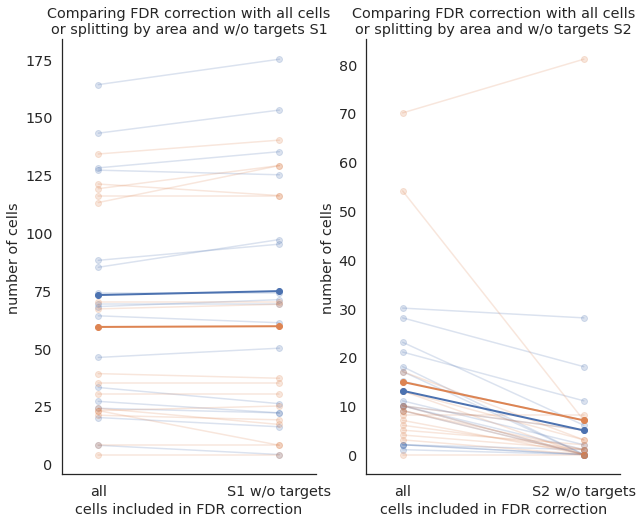

In [98]:
# plot a line using two points between all of the _all and _notarget

alpha = 0.2

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,8))

for pair in list(zip(pr_s1_all, pr_s1_notarget)):
    axs[0].plot(pair, 'C0', marker='o', alpha=alpha)

for pair in list(zip(ps_s1_all, ps_s1_notarget)):
    axs[0].plot(pair, 'C1', marker='o', alpha=alpha)
    
axs[0].plot([np.mean(pr_s1_all), np.mean(pr_s1_notarget)], 'C0', lw=2, marker='o')
axs[0].plot([np.mean(ps_s1_all), np.mean(ps_s1_notarget)], 'C1', lw=2, marker='o')
    
for pair in list(zip(pr_s2_all, pr_s2_notarget)):
    axs[1].plot(pair, 'C0', marker='o', alpha=alpha)

for pair in list(zip(ps_s2_all, ps_s2_notarget)):
    axs[1].plot(pair, 'C1', marker='o', alpha=alpha)

axs[1].plot([np.mean(pr_s2_all), np.mean(pr_s2_notarget)], 'C0', lw=2, marker='o')
axs[1].plot([np.mean(ps_s2_all), np.mean(ps_s2_notarget)], 'C1', lw=2, marker='o')
    
area = ['S1', 'S2']
for i,ax in enumerate(axs):
    ax.set_xlim(-0.2, 1.2)
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(['all', '{0} w/o targets'.format(area[i])])
    ax.set_xlabel('cells included in FDR correction')
    ax.set_ylabel('number of cells responding')
    ax.set_title('Comparing FDR correction with all cells\nor splitting by area and w/o targets {0}'.format(area[i]))

### Play with data from individual session objects

In [3]:
# List of pickle object file names, i.e. experiments that have been analysed
# '2019-06-11_J048', # -- OBFOV shallow 
# '2019-06-13_J052', # -- OBFOV shallow 
# '2019-06-25_RL048', # -- OBFOV shallow 
# '2019-07-15_RL052', # -- OBFOV shallow 
# '2019-08-14_J058', # -- OBFOV shallow 
# '2019-08-14_J059', # -- OBFOV shallow 
# '2019-08-15_RL055', # -- OBFOV shallow 
# '2019-11-14_J061', # -- shallow 
# '2019-11-14_J063', # -- shallow
# '2019-11-15_J064', # -- shallow
# '2019-11-18_J065', # -- shallow
# '2020-02-27_RL075', # -- shallow
# '2020-03-03_RL074', # -- shallow
# '2020-03-05_RL070', # -- shallow
# '2020-03-05_RL072', # -- shallow
# '2020-06-03_RL086', # -- shallow (JR stim)
##===NOT ANALYSED===##
# '2020-03-12_RL070', # -- deep
# '2020-03-16_RL074', # -- deep
# '2020-03-19_RL075', # -- deep
# '2020-06-08_RL086', # -- deep
##===NOT ANALYSED===##
# '2020-06-15_RL086', # -- auditory
# '2020-03-20_RL080', # -- shallow (failed)
# '2020-09-03_RL091', # -- shallow
# '2020-09-04_RL093', # -- shallow
# '2020-09-08_RL095', # -- shallow
# '2020-09-08_RL099', # -- shallow
# '2020-09-09_RL096', # -- shallow
# '2020-09-09_RL100', # -- shallow
# '2020-09-14_RL101', # -- shallow
# '2020-09-15_RL102', # -- shallow
# '2020-09-16_RL103', # -- shallow
# '2020-10-02_RL108', # -- shallow
# '2020-10-12_RL109', # -- shallow
# '2020-10-29_RL111', # -- projection
# '2020-12-10_RL115', # -- projection
# '2021-01-06_RL120', # -- interneuron
# '2021-01-20_RL121', # -- interneuron
# '2021-01-20_RL125', # -- interneuron
# '2021-01-20_RL124', # -- interneuron
# '2021-01-28_RL124', # -- interneuron
# '2021-02-18_RL127', # -- projection
# '2021-02-22_RL128', # -- projection
# '2021-02-23_RL129', # -- projection
# '2021-02-24_RL132', # -- projection
# '2021-02-25_RL131', # -- projection
# '2021-03-02_RL130', # -- projection

pkl_path = os.path.join(pkl_folder, '2020-09-04_RL093.pkl')

with open(pkl_path, 'rb') as f:
    ses_obj = pickle.load(f)
    
print('Loaded pickled object.')

Loaded pickled object.


In [4]:
# Show all attributes in ses_obj or exp_objs
print('Session object attributes')
for key, value in vars(ses_obj).items():
    print(key, type(value))

print('\nExperimental object attributes')
for key, value in vars(ses_obj.spont).items():
    print(key, type(value))

Session object attributes
ss_id <class 'str'>
sheet_name <class 'str'>
s2p_path <class 'str'>
photostim_r <class 'utils.interareal_analysis.interarealAnalysis'>
photostim_s <class 'utils.interareal_analysis.interarealAnalysis'>
whisker_stim <class 'utils.interareal_analysis.interarealAnalysis'>
spont <class 'utils.interareal_analysis.interarealAnalysis'>
frame_list <class 'numpy.ndarray'>

Experimental object attributes
tiff_path <class 'numpy.str_'>
naparm_path <class 'numpy.str_'>
paq_path <class 'numpy.str_'>
sheet_name <class 'str'>
s2p_path <class 'str'>
stim_channel <class 'str'>
stim_type <class 'str'>
fps <class 'float'>
frame_x <class 'int'>
frame_y <class 'int'>
n_planes <class 'int'>
pix_sz_x <class 'float'>
pix_sz_y <class 'float'>
scan_x <class 'float'>
scan_y <class 'float'>
zoom <class 'float'>
n_frames <class 'numpy.int32'>
last_good_frame <class 'str'>
frames <class 'range'>
n_groups <class 'int'>
n_reps <class 'int'>
n_shots <class 'int'>
inter_point_delay <class 'int

### Compare responses of same cells across trial types

In [ ]:
pkl_files = [file for file in os.listdir(pkl_folder) if 'RL086.pkl' in file]

values = []
times = [] 

for pkl in pkl_files:
    
    print(pkl)
    
    pkl_path = os.path.join(pkl_folder, pkl)

    with open(pkl_path, 'rb') as f:
        ses_obj = pickle.load(f)
    
    if ses_obj.whisker_stim.n_frames > 0:
        
        rand = ses_obj.photostim_r
        sens = ses_obj.photostim_s
        whis = ses_obj.whisker_stim

        exp_list = [rand, sens]

        time = whis.time
        value = np.full([2, 3, whis.time.shape[0]], np.nan)
        
        rand_sign = rand.sta_amplitudes[0] < 0
        rand_targ = rand.targeted_cells & rand.sta_sig[0]
        rand_s1_nt = rand.cell_s1[0] & ~rand.targeted_cells & rand.sta_sig[0] & rand_sign
        rand_s2 = rand.cell_s2[0] & rand.sta_sig[0] & rand_sign
        
        sens_sign = sens.sta_amplitudes[0] < 0
        sens_targ = sens.targeted_cells & sens.sta_sig[0]
        sens_s1_nt = sens.cell_s1[0] & ~sens.targeted_cells & sens.sta_sig[0] & sens_sign
        sens_s2 = sens.cell_s2[0] & sens.sta_sig[0] & sens_sign

        sens_t_whis = np.mean(whis.stas[0][sens_targ], axis=0)
        sens_s1_nt_whis = np.mean(whis.stas[0][sens_s1_nt], axis=0)
        sens_s2_whis = np.mean(whis.stas[0][sens_s2], axis=0)

        rand_t_whis = np.mean(whis.stas[0][rand_targ], axis=0)
        rand_s1_nt_whis = np.mean(whis.stas[0][rand_s1_nt], axis=0)
        rand_s2_whis = np.mean(whis.stas[0][rand_s2], axis=0)

        value[0, 0, :rand_t_whis.shape[0]] = rand_t_whis
        value[0, 1, :rand_s1_nt_whis.shape[0]] = rand_s1_nt_whis
        value[0, 2, :rand_s2_whis.shape[0]] = rand_s2_whis
        value[1, 0, :sens_t_whis.shape[0]] = sens_t_whis
        value[1, 1, :sens_s1_nt_whis.shape[0]] = sens_s1_nt_whis
        value[1, 2, :sens_s2_whis.shape[0]] = sens_s2_whis

        values.append(value)
        times.append(time)

### Plot target responses to opposing photostim

In [ ]:
plot_times = []

min_time = np.inf

for time in times:
    for t in time:
        real_times = ~np.isnan(t)
        time_len = np.sum(real_times)

        if time_len < min_time and time_len > 0: 
            min_time = time_len
            plot_time = (t[np.where(real_times)])
    
new_values = np.full([len(values), 2, 2, min_time], np.nan)

for exp_id, (value, time) in enumerate(zip(values, times)):
    
    for i in range(2):
        
        y = value[i]
        x = time[i]
        f = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)

        xnew = plot_time
        new_values[exp_id, i, :, :len(xnew)] = f(xnew)
                
# new_values = [session x pr/ps x pos/neg x targ/s1/s2 x time]
n_data_samples = np.prod(new_values.shape[:-1]) # len y
len_sample = plot_time.shape[0] # len x

df_time = np.tile(plot_time, n_data_samples) # x for flattened data

targets = np.concatenate((np.repeat('pr', len_sample*2), np.repeat('ps', len_sample*2))) # one experiment, one stim, one sign
df_target = np.tile(targets, int(n_data_samples/4))

stim = np.concatenate((np.repeat('self', len_sample), np.repeat('other', len_sample))) # one experiment
df_stim = np.tile(stim, int(n_data_samples/2))

dff = new_values.flatten()

In [ ]:
df = pd.DataFrame({'dff' : dff,
                   'time' : df_time,
                   'target' : df_target,
                   'stim_type' : df_stim
                  })

In [ ]:
g = sns.FacetGrid(df, col='target', row='stim_type', sharex=True, sharey=True, size=4)
g.map(sns.lineplot, 'time', 'dff')
axes = g.axes

for ax in axes.reshape(-1):
    ax.hlines(0, -2, 10, linestyles='dashed', zorder=5)
    
save_path = os.path.join(fig_save_path, 'for_manuscript', 'target_responses_on_self_other_photostim_trials')
plt.savefig(save_path + '.svg', bbox_inches='tight')

### Plot the bias of target responses to sensory-responsive cells

In [36]:
pkl_files = [file for file in os.listdir(pkl_folder) if '.pkl' in file]

# literally, the number of whisker + photoresponsive target cells
num_w_cells = np.full([len(pkl_files), 2], np.nan)
amp_w_cells = np.full([len(pkl_files), 2], np.nan)
targ_w_cells = np.full([len(pkl_files), 2], np.nan)

for exp_id, pkl in enumerate(pkl_files):
    
    print(pkl)
    
    pkl_path = os.path.join(pkl_folder, pkl)

    with open(pkl_path, 'rb') as f:
        ses_obj = pickle.load(f)
    
    if ses_obj.whisker_stim.n_frames > 0:
        
        w = np.array(ses_obj.whisker_stim.sta_sig[0] &
                     (ses_obj.whisker_stim.sta_amplitudes[0] > 0)) # positive whisker responder bool
        w_resp = np.where(ses_obj.whisker_stim.sta_sig[0])[0] # whisker responder ids
        w_pos = np.where(w) # positive whisker responder ids
        
        pr_targ = ses_obj.photostim_r.targeted_cells # random targets bool
        pr_resp = np.where(ses_obj.photostim_r.sta_sig[0] & pr_targ)[0] # random target responder ids
        pr_cells = np.where(pr_targ)[0] # random target ids
        pr_w_targ = np.sum(w[pr_cells]) # count of random targets that are +ve whisker responders
        pr_w = np.intersect1d(pr_resp, w_resp) # cells that are random target responders and whisker responders
        num_pr_w = np.sum(w[pr_resp]) # count of +ve whisker responders that are random target responders
        amp_pr_w = np.sum(ses_obj.whisker_stim.sta_amplitudes[0][pr_w]) # sum whisker response of random target|whisker responders
        
        ps_targ = ses_obj.photostim_s.targeted_cells # sensory targets
        ps_cells = np.where(ps_targ)[0] # sensory target ids
        ps_resp = np.where(ses_obj.photostim_s.sta_sig[0] & ps_targ)[0] # sensory target responder ids
        ps_w_targ = np.sum(w[ps_cells]) # total sensory targets that are whisker responders
        ps_w = np.intersect1d(ps_resp, w_resp) # cells that are sensory target responders and whisker responders  
        num_ps_w = ps_w.shape[0] # count of the above
        amp_ps_w = np.sum(ses_obj.whisker_stim.sta_amplitudes[0][ps_w]) # sum whisker response of random target|whisker responders
        
        num_w_cells[exp_id] = [num_pr_w, num_ps_w] # total number that are target responder & whisker responders
        amp_w_cells[exp_id] = [amp_pr_w, amp_ps_w] # sum of response amplitudes for target responder & whisker responders
        targ_w_cells[exp_id] = [pr_w_targ, ps_w_targ] # total number that are target & whisker responder

num_w_cells = num_w_cells[~np.isnan(num_w_cells)].reshape(-1,2)
amp_w_cells = amp_w_cells[~np.isnan(amp_w_cells)].reshape(-1,2)
targ_w_cells = targ_w_cells[~np.isnan(targ_w_cells)].reshape(-1,2)
mean_w_cells = amp_w_cells/num_w_cells

2019-11-14_J061.pkl
2019-11-14_J063.pkl
2019-11-15_J064.pkl
2019-11-18_J065.pkl
2020-02-27_RL075.pkl
2020-03-03_RL074.pkl
2020-03-05_RL070.pkl
2020-03-05_RL072.pkl
2020-09-04_RL093.pkl
2020-09-08_RL099.pkl
2020-09-09_RL100.pkl
2020-09-14_RL101.pkl
2020-09-15_RL102.pkl
2020-09-16_RL103.pkl
2020-10-02_RL108.pkl
2020-10-12_RL109.pkl


In [65]:
stats.ttest_ind(mean_w_cells[:,1], mean_w_cells[:,0], equal_var=False)

Ttest_indResult(statistic=3.8130681772763055, pvalue=0.0010725645932346025)

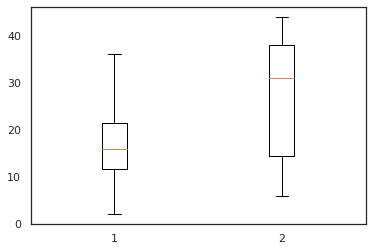

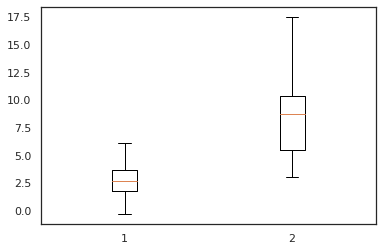

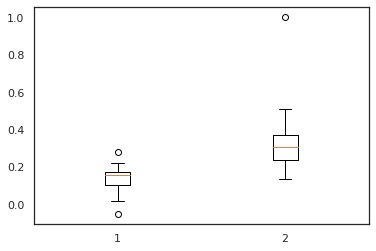

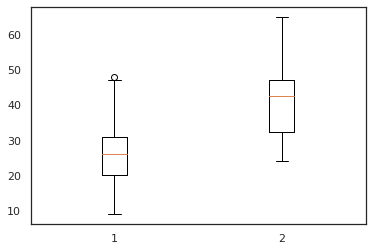

In [66]:
save_path = os.path.join(fig_save_path, 'for_manuscript', 'target_w_bias_')

plt.figure()
plt.boxplot([num_w_cells[:,0], num_w_cells[:,1]]);
# plt.savefig(save_path + 'num.svg', bbox_inches='tight')

plt.figure()
plt.boxplot([amp_w_cells[:,0], amp_w_cells[:,1]]);
# plt.savefig(save_path + 'dff_sum.svg', bbox_inches='tight')

plt.figure()
plt.boxplot([mean_w_cells[:,0], mean_w_cells[:,1]]);
# plt.savefig(save_path + 'dff_mean.svg', bbox_inches='tight')

plt.figure()
plt.boxplot([targ_w_cells[:,0], targ_w_cells[:,1]]);
# plt.savefig(save_path + 'targ_num.svg', bbox_inches='tight')

### Plot negative, positive and unresponsive target, s1_nt and s2 cells 

In [ ]:
obj = ses_obj.photostim_r

time = obj.time

pos_amps = obj.sta_amplitudes[0] > 0
neg_amps = obj.sta_amplitudes[0] < 0

targ_bool = obj.targeted_cells & obj.sta_sig[0]
s1_nt_bool_pos = obj.cell_s1[0] & ~obj.targeted_cells & obj.sta_sig[0] & pos_amps
s1_nt_bool_neg = obj.cell_s1[0] & ~obj.targeted_cells & obj.sta_sig[0] & neg_amps
s1_nt_bool_unr = obj.cell_s1[0] & ~obj.targeted_cells & ~obj.sta_sig[0]
s2_bool_pos = obj.cell_s2[0] & obj.sta_sig[0] & pos_amps
s2_bool_neg = obj.cell_s2[0] & obj.sta_sig[0] & neg_amps
s2_bool_unr = obj.cell_s2[0] & ~obj.sta_sig[0]
# spont_bool = obj.cell_s2[0] & ~obj.sta_sig[0]

In [ ]:
obj = ses_obj.photostim_r
stas = obj.stas[0]

fig, axes = plt.subplots(figsize=(7.5,5))

# id_list = [s1_nt_bool_unr,
#            s1_nt_bool_pos,
#            s1_nt_bool_neg
#           ]

id_list = [targ_bool]

# linestyle = ['dotted',
#               'dashed',
#               'solid'
#              ]

# colours = ['grey',
#            'indianred',
#            'slateblue'
#           ]

colours = ['black']

for i, ids in enumerate(id_list):
    
    x= time

    mean, std, ci, sem = meanError(stas[ids], axis=0, n=np.sum(ids))

    y= mean

    axes.plot(x, y, color=colours[i], ls='solid', lw=2)
    axes.fill_between(x, y + sem, y - sem, color=colours[i], alpha=0.6, zorder=1);
    axes.hlines(0, np.amin(x), np.amax(x), linestyles='dotted', zorder=4, alpha=0.3);
    
    # construct patch to cover stim artifact period
    stim_patch = patches.Rectangle((0,-100), obj.duration_frames/obj.fps, 999, zorder=3, color='white', lw=2, ec='white')
    axes.add_patch(stim_patch)

    axes.autoscale(enable=True, axis='x', tight=True)
    axes.set_xlabel('time (seconds)');
    axes.set_ylabel('ΔF/F');
    axes.set_ylim([-0.15, 0.9])
    axes.set_title('Responses of non-targeted cells in S2')
    
save_path = os.path.join(fig_save_path, 'for_manuscript', 'RL070_target_responders_mean_dff_trace_v3')
plt.savefig(save_path + '.svg', bbox_inches='tight')

In [ ]:
cell_med = np.array(obj.cell_med[0])[np.where(s1_nt_bool_pos)]

plt.scatter(cell_med[:,1], cell_med[:,0])
plt.axis([0, 1024, 1024, 0])
ax = plt.gca()
ax.set_aspect('equal')

### Find extreme cells (those that have large, noisy changes in dFF)

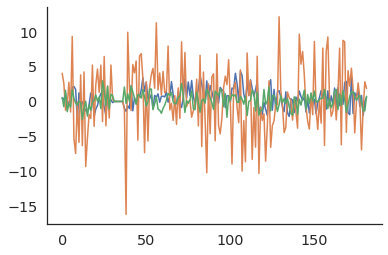

[ 836 1271 3132]


In [28]:
obj = ses_obj.photostim_r

obj.stas[0].shape
stas = obj.stas[0]
std_baseline = np.std(stas[:, :obj.pre_frames], axis=1)

extreme_cells = std_baseline > 1

plt.plot(stas[extreme_cells].transpose());
plt.show();
s2p_ids = np.array(obj.cell_id[0])[np.where(extreme_cells)[0]]
print(s2p_ids)

### Average traces for targets, non-targets in S1 and non-targets in S2

In [129]:
stim_types = ['pr', 
              'ps',
#               'none', 
#               'w'
             ]

pkl_files = [file for file in os.listdir(pkl_folder) if '.pkl' in file]

values = []
times = [] 

num_cells = np.full([len(pkl_files), len(stim_types), 2, 3], np.nan)

for exp_id, pkl in enumerate(pkl_files):
    
    print(pkl)
    
    pkl_path = os.path.join(pkl_folder, pkl)

    with open(pkl_path, 'rb') as f:
        ses_obj = pickle.load(f)

    exp_list = []
    exp_list.extend([ses_obj.photostim_r, 
                     ses_obj.photostim_s])
    if ses_obj.spont.n_frames > 0: exp_list.append(ses_obj.spont)            
    if ses_obj.whisker_stim.n_frames > 0: exp_list.append(ses_obj.whisker_stim)
    
    time_len_max = 0
    
    for exp in exp_list:
        if exp.time.shape[0] > time_len_max:
            time_len_max = exp.time.shape[0]
            
    time = np.full([len(stim_types), time_len_max], np.nan)
    value = np.full([len(stim_types), 2, 3, time_len_max], np.nan)

    for stim_id, stim_type in enumerate(stim_types):

        for _,obj in enumerate(exp_list):

            signed_amps = [obj.sta_amplitudes[0] > 0,
                           obj.sta_amplitudes[0] < 0
                          ]

            # for spont data
#                 signed_amps = [ses_obj.spont.sta_amplitudes[0] > 0,
#                                ses_obj.spont.sta_amplitudes[0] < 0
#                               ]

            for sign_id, signed_amp in enumerate(signed_amps):

                if obj.stim_type == stim_type:

                    if stim_type == 'none':
                        targ_bool = ses_obj.photostim_r.targeted_cells & obj.sta_sig[0]
                        s1_nt_bool = obj.cell_s1[0] & ~ses_obj.photostim_r.targeted_cells &\
                                     obj.sta_sig[0] & signed_amp
                    else:
                        targ_bool = obj.targeted_cells & obj.sta_sig[0]
                        s1_nt_bool = obj.cell_s1[0] & ~obj.targeted_cells & obj.sta_sig[0] & signed_amp

                    s2_bool = obj.cell_s2[0] & obj.sta_sig[0] & signed_amp

                    # non-sig cells
#                     targ_bool = obj.targeted_cells & ~obj.sta_sig[0]
#                     s2_bool = obj.cell_s2[0] & ~obj.sta_sig[0]
#                     s1_nt_bool = obj.cell_s1[0] & ~obj.sta_sig[0] & ~obj.targeted_cells

                    num_cells[exp_id, stim_id, sign_id] = [np.sum(targ_bool), np.sum(s1_nt_bool), np.sum(s2_bool)]

                    all_trials = obj.all_trials[0]

                    # using spont data
#                         all_trials = ses_obj.spont.all_trials[0]

                    targ_trials = np.nanmean(all_trials[targ_bool], axis=(0,2))
                    s2_trials = np.nanmean(all_trials[s2_bool], axis=(0,2))
                    s1_nt_trials = np.nanmean(all_trials[s1_nt_bool], axis=(0,2))

                    value[stim_id, sign_id, :, :all_trials.shape[1]] = np.stack((targ_trials, s1_nt_trials, s2_trials))

                    time[stim_id, :obj.time.shape[0]] = obj.time

    values.append(value)
    times.append(time)

2019-11-14_J061.pkl
2019-11-14_J063.pkl
2019-11-15_J064.pkl


KeyboardInterrupt: 

In [23]:
stim_types = ['pr', 'ps', 'none'] # 'pr', 'ps', 'none'
signs = ['all'] # 'all', 'pos', 'neg'
cell_types = ['s1_targ', 's1_nontarg', 's2'] # 's1_targ', 's1_nontarg', 's2'
sig = ['fdr'] # 'fdr', 'nomulti', 'non-fdr', 'non-nomulti'

pkl_files = listdirFullpath(pkl_folder, '.pkl')

values = []
times = []

num_cells = np.full([len(pkl_files), len(stim_types), len(signs), len(cell_types)], np.nan)

for exp_id, pkl in enumerate(pkl_files):
    
    ses_obj = loadPickle(pkl)
    
    exp_list = makeExpList(ses_obj, stim_types)
    
    trial_len_max = getMaxTrialLength(exp_list)
            
    time_array = np.full([len(stim_types), trial_len_max], np.nan)
    value_array = np.full([len(stim_types), len(signs), len(cell_types), trial_len_max], np.nan)

    for stim_id, stim_type in enumerate(stim_types):

        for exp_obj in exp_list:
            
            if exp_obj.stim_type == stim_type:
        
                signed_amps = []
                if 'pos' in signs: signed_amps.append(exp_obj.sta_amplitudes[0] > 0)
                if 'neg' in signs: signed_amps.append(exp_obj.sta_amplitudes[0] < 0)
                if 'all' in signs: signed_amps.append(np.full_like(exp_obj.sta_amplitudes[0], True, dtype=bool))
                
                for sign_id, signed_amp in enumerate(signed_amps):

                    responders = getResponderIdentities(exp_obj, signed_amp, sig='fdr') # 'fdr', 'nomulti', 'insig-fdr' or 'insig-nomulti'
                    num_cells[exp_id, stim_id, sign_id] = np.sum(responders, axis=1)

                    trials = getResponderTrials(exp_obj, responders)

                    trial_len = exp_obj.all_trials[0].shape[1]
                    value_array[stim_id, sign_id, :, :trial_len] = np.stack((trials))

                    time_array[stim_id, :len(exp_obj.time)] = exp_obj.time

    values.append(value_array)
    times.append(time_array)

Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J061.pkl


/home/rlees/Documents/Code/Vape/jupyter/rob/ia_funcs.py:982: RuntimeWarning: Mean of empty slice
  s1_targ_trials = np.nanmean(all_trials[responders[0]], axis=(0,2)) # mean across cell and trial
/home/rlees/Documents/Code/Vape/jupyter/rob/ia_funcs.py:983: RuntimeWarning: Mean of empty slice
  s1_nt_trials = np.nanmean(all_trials[responders[1]], axis=(0,2))


Loading pickle: /home/rlees/mnt/qnap/pkl_files/2019-11-14_J063.pkl


KeyboardInterrupt: 

### Plot average traces using Seaborn

In [59]:
plot_times = []

min_time = np.inf

for stim_id, stim_type in enumerate(stim_types):

    for time in times:
        trial_time = time[stim_id]
        real_times = ~np.isnan(trial_time)
        time_len = np.sum(real_times)
        
        if time_len < min_time and time_len > 0: 
            min_time = time_len
            plot_time = (trial_time[np.where(real_times)])
    
new_values = np.full([len(values), len(stim_types), 2, 3, min_time], np.nan)

for stim_id, stim_type in enumerate(stim_types):
    
    for exp_id, (value, time) in enumerate(zip(values, times)):
        
        for sign_id in range(2):
            
            for cell_type in range(3):
            
                y = value[stim_id, sign_id, cell_type]
                x = time[stim_id]
                f = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)

                xnew = plot_time
                new_values[exp_id, stim_id, sign_id, cell_type, :len(xnew)] = f(xnew)
                
# new_values = [session x pr/ps x pos/neg x targ/s1/s2 x time]
n_data_samples = np.prod(new_values.shape[:-1]) # len y
len_sample = plot_time.shape[0] # len x

df_time = np.tile(plot_time, n_data_samples) # x for flattened data

area = np.concatenate((np.repeat('target', len_sample), np.repeat('s1_nt', len_sample), np.repeat('s2', len_sample))) # one experiment, one stim, one sign
df_area = np.tile(area, int(n_data_samples/3))

sign = np.concatenate((np.repeat('pos', len_sample*3), np.repeat('neg', len_sample*3))) # one experiment, one stim
df_sign = np.tile(sign, int(n_data_samples/6))

stim = np.concatenate((np.repeat('pr', len_sample*6), np.repeat('ps', len_sample*6))) # one experiment
df_stim = np.tile(stim, int(n_data_samples/12))

dff = new_values.flatten()

In [60]:
df = pd.DataFrame({'dff' : dff,
                   'time' : df_time,
                   'area' : df_area,
                   'sign' : df_sign,
                   'trial_type' : df_stim
                  })

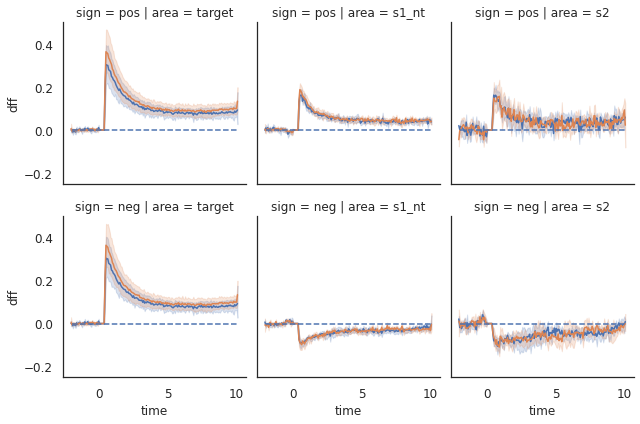

In [61]:
g = sns.FacetGrid(df, col='area', row='sign', hue='trial_type', sharex=True, sharey='row')
g.map(sns.lineplot, 'time', 'dff')
axes = g.axes

for ax in axes.reshape(-1):
    ax.hlines(0, -2, 10, linestyles='dashed', zorder=5)
    ax.set_ylim([-0.25, 0.5])
    
# save_path = os.path.join(fig_save_path, 'for_manuscript', 'dff_grand_averages_new')
# plt.savefig(save_path + '.svg', bbox_inches='tight')

### Plot average traces using Matplotlib

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


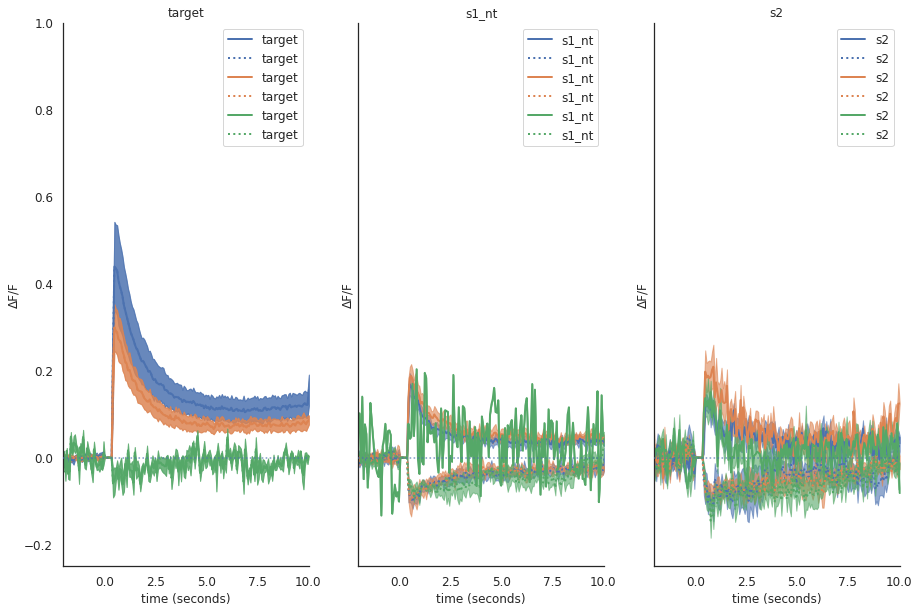

In [62]:
plot_times = []

min_time = np.inf

for stim_id, stim_type in enumerate(stim_types):

    for time in times:
        trial_time = time[stim_id]
        real_times = ~np.isnan(trial_time)
        time_len = np.sum(real_times)
        
        if time_len < min_time and time_len > 0: 
            min_time = time_len
            plot_time = (trial_time[np.where(real_times)])
    
new_values = np.full([len(values), len(stim_types), 2, 3, min_time], np.nan)

for stim_id, stim_type in enumerate(stim_types):
    
    for exp_id, (value, time) in enumerate(zip(values, times)):
        
        for sign_id in range(2):
            
            for cell_type in range(3):
            
                y = value[stim_id, sign_id, cell_type]
                x = time[stim_id]
                f = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)

                xnew = plot_time
                new_values[exp_id, stim_id, sign_id, cell_type, :len(xnew)] = f(xnew)
            
mean_values = np.nanmean(new_values, axis=0)
std_values = np.nanstd(new_values, axis=0)
ci_values = 1.960 * (std_values/np.sqrt(new_values.shape[0])) # 1.960 is z for 95% confidence interval, standard deviation divided by the sqrt of N samples (# cells)

cell_types = ['target', 's1_nt', 's2']
linestyles = ['solid', 'dotted', 'dashed']

fig, axes = plt.subplots(nrows=1, ncols=len(cell_types), sharey=True, sharex=True, figsize=(15,10))

for cell_id, cell_type in enumerate(cell_types):

    x = plot_time
    
    for stim_id, stim_type in enumerate(stim_types):
        
        for sign_id in range(2):
            
            y = mean_values[stim_id, sign_id, cell_id]
            y_std = std_values[stim_id, sign_id, cell_id]
            y_ci = ci_values[stim_id, sign_id, cell_id]

            axes[cell_id].plot(x, y, color=plotColour(stim_type), linestyle=linestyles[sign_id], 
                               lw=2, label=cell_type
                              )
    #         axes[stim_id].fill_between(x, y + y_std, y - y_std, color=plotColour(stim_type),
    #                                    alpha=0.6, zorder=1);
            axes[cell_id].fill_between(x, y + y_ci, y - y_ci, color=plotColour(stim_type),
                                       alpha=0.6, zorder=1);

        axes[cell_id].hlines(0, np.amin(x), np.amax(x), linestyles='dotted', zorder=4, alpha=0.3);
        axes[cell_id].autoscale(enable=True, axis='x', tight=True)
        axes[cell_id].set_xlabel('time (seconds)');
        axes[cell_id].set_ylabel('ΔF/F');
        axes[cell_id].set_title(cell_types[cell_id]);
        axes[cell_id].set_ylim([-0.25, 1])
        axes[cell_id].legend();

# save_path = os.path.join(fig_save_path, 'for_manuscript', 'grand_mean_dff_trace_spont_prpsfauxresponders_v2')
# plt.savefig(save_path + '.png', bbox_inches='tight')

In [66]:
num_cells[0]

array([[[37., 15.,  3.],
        [37.,  7.,  2.]],

       [[27.,  5., 72.],
        [27.,  3.,  9.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  2.]]])

[[764 529  33]
 [669 429  84]
 [  9   1   7]]


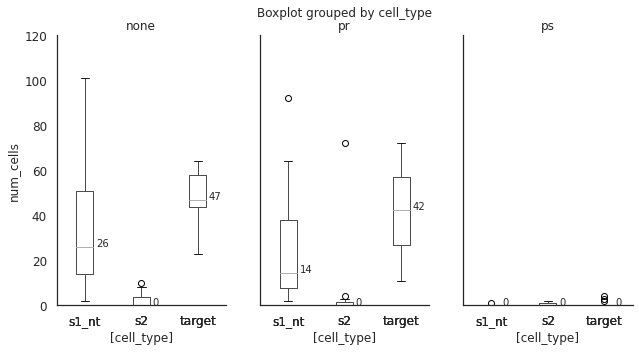

In [82]:
num_cells_2 = num_cells[:, :, 0, :] # [pickle x stim x sign x cell_type]
total_cells = np.nansum(num_cells_2, axis=0, dtype=int)
median_cells = np.nanmedian(num_cells_2, axis=0)
a = num_cells_2.swapaxes(1,2)
s = a.shape
a.reshape(s[0]*s[1], -1)

df = pd.DataFrame(a.reshape(s[0]*s[1], -1), columns=['none', 'pr', 'ps'])

df['cell_type'] = np.tile(cell_types, s[0])

axes = df.boxplot(by='cell_type', grid=False, figsize=(10,5), layout=(1,3), return_type='axes');
axes[0].set_ylabel('num_cells');

for ax_id, ax in enumerate(axes):
    
    ax.set_ylim([0, 120])
    
    for pos, value_i in enumerate([1,2,0]):
        median_value = median_cells[ax_id, value_i]
        ax.text(pos+1.2, median_value, str(int(median_value)))
        
# save_path = os.path.join(fig_save_path, 'for_manuscript', 'numcells_responders_pr_ps_targ_s1_nt_s2_-ve')
# plt.savefig(save_path + '.svg', bbox_inches='tight')

print(total_cells)

### Summed activity in targets, non-targets in S1 and non-targets in S2

In [23]:
stim_types = ['pr', 
              'ps',
#               'none', 
#               'w'
             ]

pkl_files = [file for file in os.listdir(pkl_folder) if '.pkl' in file]

dff_sum = np.full([len(stim_types), len(pkl_files), 3], np.nan)
dff_mean = np.full([len(stim_types), len(pkl_files), 3], np.nan)

for exp_id, pkl in enumerate(pkl_files):
    
    print(pkl)
    
    pkl_path = os.path.join(pkl_folder, pkl)

    with open(pkl_path, 'rb') as f:
        ses_obj = pickle.load(f)

    exp_list = []
    exp_list.extend([ses_obj.photostim_r, 
                     ses_obj.photostim_s])
    if ses_obj.spont.n_frames > 0: exp_list.append(ses_obj.spont)            
    if ses_obj.whisker_stim.n_frames > 0: exp_list.append(ses_obj.whisker_stim)
    
    for stim_id, stim_type in enumerate(stim_types):

        for _,obj in enumerate(exp_list):
            
            signed_cells = obj.sta_amplitudes[0] < 0
            
            if obj.stim_type == stim_type:
                targ_bool = obj.targeted_cells & obj.sta_sig[0]
                s2_bool = obj.cell_s2[0] & obj.sta_sig[0] & signed_cells
                s1_nt_bool = obj.cell_s1[0] & ~obj.targeted_cells & obj.sta_sig[0] & signed_cells
                
                dff_sum[stim_id, exp_id, 0] = np.nansum(obj.sta_amplitudes[0][targ_bool])
                dff_mean[stim_id, exp_id, 0] = np.nanmean(obj.sta_amplitudes[0][targ_bool])
                
                dff_sum[stim_id, exp_id, 1] = np.nansum(obj.sta_amplitudes[0][s1_nt_bool])
                dff_mean[stim_id, exp_id, 1] = np.nanmean(obj.sta_amplitudes[0][s1_nt_bool])
                
                dff_sum[stim_id, exp_id, 2] = np.nansum(obj.sta_amplitudes[0][s2_bool])
                dff_mean[stim_id, exp_id, 2] = np.nanmean(obj.sta_amplitudes[0][s2_bool])                
                
dff_sum_norm = np.empty_like(dff_sum)
dff_mean_norm = np.empty_like(dff_mean)

for s_i in range(dff_sum.shape[0]):
    for t_i in range(dff_sum.shape[-1]):
        dff_sum_norm[s_i, :, t_i] = dff_sum[s_i, :, t_i]/dff_sum[s_i, :, 0]
        dff_mean_norm[s_i, :, t_i] = dff_mean[s_i, :, t_i]/dff_mean[s_i, :, 0]

2019-11-14_J061.pkl
2019-11-14_J063.pkl
2019-11-15_J064.pkl
2019-11-18_J065.pkl


/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


2020-02-27_RL075.pkl
2020-03-03_RL074.pkl
2020-03-05_RL070.pkl
2020-03-05_RL072.pkl
2020-09-04_RL093.pkl
2020-09-08_RL099.pkl
2020-09-09_RL100.pkl
2020-09-14_RL101.pkl
2020-09-15_RL102.pkl
2020-09-16_RL103.pkl
2020-10-02_RL108.pkl
2020-10-12_RL109.pkl


In [14]:
pos_dff_sum_norm = copy.deepcopy(dff_sum_norm)
# neg_dff_sum_norm = copy.deepcopy(dff_sum_norm)

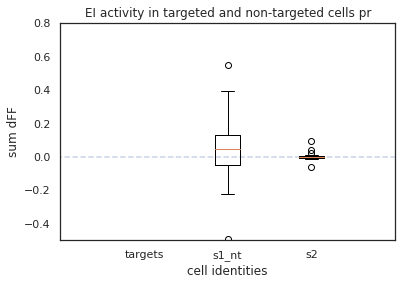

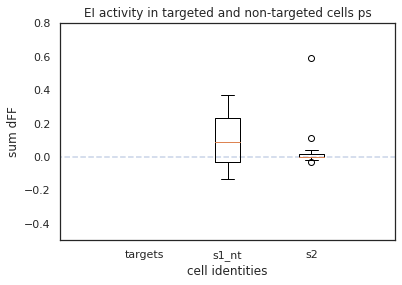

In [17]:
save_path = os.path.join(fig_save_path, 'for_manuscript', 'dff_normsum_responders_ei_')

for targ_i in range(len(stim_types)):
    plt.figure()
#     plt.boxplot(np.array([i for i in dff_mean_norm[targ_i] if not any(np.isnan(i))]));
    plt.boxplot(np.array([i for i in ei_balance[targ_i] if not any(np.isnan(i))]));
    plt.hlines(0, -1, 5, linestyles='--', alpha=0.3, zorder=1)
    plt.xlim([0, 4])
    plt.xticks([1,2,3], ['targets', 's1_nt', 's2']);
    plt.xlabel('cell identities')
    plt.ylabel('sum dFF')
    plt.ylim([-0.5, 0.8]) # for mean
#     plt.ylim([-20, 80]) # for sum
    plt.title('EI activity in targeted and non-targeted cells ' + stim_types[targ_i]);
#     plt.savefig(save_path + stim_types[targ_i] + '.svg', bbox_inches='tight')

In [16]:
# EI balance stats test

ei_balance = pos_dff_sum_norm + neg_dff_sum_norm
# stats.wilcoxon(ei_balance[0,:,2], ei_balance[0,:,1])
print(stats.ttest_1samp(ei_balance[0,:,1], 0))
print(stats.ttest_1samp(ei_balance[1,:,1], 0))

Ttest_1sampResult(statistic=0.6971742824562907, pvalue=0.4963579007478034)
Ttest_1sampResult(statistic=1.8720053348099404, pvalue=0.08083488850229653)


### Input-output curve for targets vs. S1/S2 non-targets

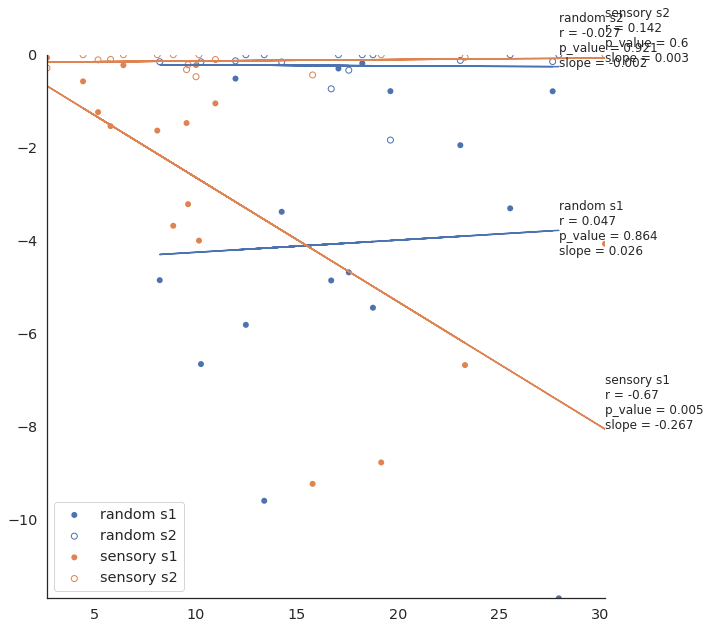

In [24]:
save_path = os.path.join(fig_save_path, 'for_manuscript', 'pos_input_output_sum_dff_v3')

plt.figure(figsize=(10,10))
# pr
x = dff_sum[0, :, 0] #targ
y = dff_sum[0, :, 1] #s1

plt.scatter(x, y, c='C0', edgecolor='none', marker='o', label='random s1') #blue fill
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), 'C0')

slope, _, r_value, p_value, _ = stats.linregress(x,y)
plt.text(np.amax(x), np.amin(p(x)), 'random s1' + 
         '\nr = ' + str(round(r_value, 3)) + 
         '\np_value = ' + str(round(p_value, 3)) +
         '\nslope = ' + str(round(slope, 3)))

y = dff_sum[0, :, 2] #s2

plt.scatter(x, y, c='none', edgecolor='C0', marker='o', label='random s2') #blue non-fill
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), 'C0')

plt.autoscale(enable=True,axis='both',tight=True)

slope, _, r_value, p_value, _ = stats.linregress(x,y)
plt.text(np.amax(x), np.amin(p(x)), 'random s2' + 
         '\nr = ' + str(round(r_value, 3)) + 
         '\np_value = ' + str(round(p_value, 3)) +
         '\nslope = ' + str(round(slope, 3)));

#ps
x = dff_sum[1, :, 0] #targ
y = dff_sum[1, :, 1] #s1

plt.scatter(x, y, c='C1', edgecolor='none', marker='o', label='sensory s1') #orange fill
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), 'C1')

slope, _, r_value, p_value, _ = stats.linregress(x,y)
plt.text(np.amax(x), np.amin(p(x)), 'sensory s1' + 
         '\nr = ' + str(round(r_value, 3)) + 
         '\np_value = ' + str(round(p_value, 3)) +
         '\nslope = ' + str(round(slope, 3)))

y = dff_sum[1, :, 2] #s2

plt.scatter(x, y, c='none', edgecolor='C1', marker='o', label='sensory s2') #orange non-fill
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), 'C1')

plt.autoscale(enable=True,axis='both',tight=True)

slope, _, r_value, p_value, _ = stats.linregress(x,y)
plt.text(np.amax(x), np.amin(p(x)), 'sensory s2' + 
         '\nr = ' + str(round(r_value, 3)) + 
         '\np_value = ' + str(round(p_value, 3)) + 
         '\nslope = ' + str(round(slope, 3)));

plt.legend(loc='lower left');
# plt.savefig(save_path + '.svg', bbox_inches='tight')

### Number of cells per mm^2 of FOV

In [29]:
pkl_files = [p for p in os.listdir(pkl_folder) if 'pkl' in p]

for pkl in pkl_files:
        
    print(pkl)

    pkl_path = os.path.join(pkl_folder, pkl)

    with open(pkl_path, 'rb') as f:
        ses_obj = pickle.load(f)

    temp_obj = ses_obj.photostim_r

    f_x_um = temp_obj.frame_x * temp_obj.pix_sz_x
    f_y_um = temp_obj.frame_y * temp_obj.pix_sz_y

    n_units = temp_obj.n_units[0]

    area_mm = (f_x_um/1000) * (f_y_um/1000)

    print('n cells:', n_units,
          '\nframe x (um):', round(f_x_um, 2),
          '\nframe y (um):', round(f_y_um, 2),
          '\narea (mm^2):', round(area_mm, 2),
          '\nn cells per mm^2:', int(n_units / area_mm), 
          end='\n\n'
         )

2019-11-14_J061.pkl
n cells: 1893 
frame x (um): 1398.13 
frame y (um): 1398.13 
area (mm^2): 1.95 
n cells per mm^2: 968

2019-11-14_J063.pkl
n cells: 2038 
frame x (um): 1398.13 
frame y (um): 1398.13 
area (mm^2): 1.95 
n cells per mm^2: 1042

2019-11-15_J064.pkl
n cells: 2123 
frame x (um): 1398.13 
frame y (um): 1398.13 
area (mm^2): 1.95 
n cells per mm^2: 1086

2019-11-18_J065.pkl


KeyboardInterrupt: 

### Difference between whisker stim response in S1 and S2

In [30]:
# Getting at the difference in avg trace between S1 and S2, S2 is larger

# Proportion of cells positive vs. negative over all - more negative in S1 would be expected

pkl_files = [p for p in os.listdir(pkl_folder) if 'pkl' in p]

sig_cells_repeat = np.ones([len(pkl_files), 2, 3])

for ses_i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        pkl_path = os.path.join(pkl_folder, pkl)
        print(pkl_path)

        with open(pkl_path, 'rb') as f:
            ses_obj = pickle.load(f)
        
        exp_list = []
        exp_list.append(ses_obj.whisker_stim if ses_obj.whisker_stim.n_frames > 0 else [])
        
        for obj in exp_list:

            # subtract spont from photostim
            all_trials = obj.all_trials[0]

            # non-parametric test with repeated measures H_A = residual > 0 (post-pre)
            pre_trial_frames = np.s_[obj.pre_frames - obj.test_frames : obj.pre_frames]
            stim_end = obj.pre_frames + obj.duration_frames
            post_trial_frames = np.s_[stim_end : stim_end + obj.test_frames]

            pre_array = np.mean(all_trials[:, pre_trial_frames, :], axis=1)
            post_array = np.mean(all_trials[:, post_trial_frames, :], axis=1)

            wilcoxons = np.empty(obj.n_units[0])

            for cell in range(obj.n_units[0]):
                wilcoxons[cell] = stats.wilcoxon(post_array[cell], pre_array[cell])[1]

            # false discovery rate correction, 5% fixed rate
            pvals = wilcoxons

            sig_cells, _, _, _ = smstats.multitest.multipletests(pvals, alpha=0.1, method='fdr_bh', 
                                                                 is_sorted=False, returnsorted=False)


            pos_cells = obj.sta_amplitudes[0]>0
            neg_cells = obj.sta_amplitudes[0]<0

            sig_s1_pos = np.sum(sig_cells & obj.cell_s1[0] & pos_cells)
            sig_s1_neg = np.sum(sig_cells & obj.cell_s1[0] & neg_cells)
            sig_s2_pos = np.sum(sig_cells & obj.cell_s2[0] & pos_cells)
            sig_s2_neg = np.sum(sig_cells & obj.cell_s2[0] & neg_cells)

            sig_cells_repeat[ses_i, 0] = [sig_s1_pos, sig_s1_neg, np.sum(obj.cell_s1[0])]
            sig_cells_repeat[ses_i, 1] = [sig_s2_pos, sig_s2_neg, np.sum(obj.cell_s2[0])]
            
sum_cells = np.sum(sig_cells_repeat, axis=0)
pc_cells_pos = sum_cells[:,0]/sum_cells[:,2]*100
pc_cells_neg = sum_cells[:,1]/sum_cells[:,2]*100

print('\nPercentage of cells responding',
      '\n+ve:',
      '\nS1:', pc_cells_pos[0],
      '\nS2:', pc_cells_pos[1],
      '\n-ve:',
      '\nS1:', pc_cells_neg[0],
      '\nS2:', pc_cells_neg[1])

/home/rlees/mnt/qnap/pkl_files/2019-11-14_J061.pkl
/home/rlees/mnt/qnap/pkl_files/2019-11-14_J063.pkl
/home/rlees/mnt/qnap/pkl_files/2019-11-15_J064.pkl
/home/rlees/mnt/qnap/pkl_files/2019-11-18_J065.pkl
/home/rlees/mnt/qnap/pkl_files/2020-02-27_RL075.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-03_RL074.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-05_RL070.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-05_RL072.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-04_RL093.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-08_RL099.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-09_RL100.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-14_RL101.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-15_RL102.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-16_RL103.pkl
/home/rlees/mnt/qnap/pkl_files/2020-10-02_RL108.pkl
/home/rlees/mnt/qnap/pkl_files/2020-10-12_RL109.pkl

Percentage of cells responding 
+ve: 
S1: 21.63826729624307 
S2: 29.21174652241113 
-ve: 
S1: 8.694313282693491 
S2: 4.861598988337783


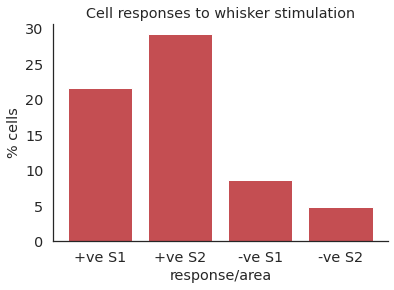

In [31]:
plt.bar([1,2,3,4], [pc_cells_pos[0], pc_cells_pos[1], pc_cells_neg[0], pc_cells_neg[1]], color='C3');
plt.xticks([1,2,3,4], ['+ve S1', '+ve S2', '-ve S1', '-ve S2']);
plt.ylabel('% cells');
plt.xlabel('response/area');
plt.title('Cell responses to whisker stimulation');

# plt.savefig(os.path.join(fig_save_path, 'whisker_stim_cell_responses_per_area.png'), bbox_inches='tight')

### Plot suite2p params for all cells in order

In [ ]:
os.chdir(ses_obj.s2p_path)
        
ops = np.load('ops.npy', allow_pickle=True).item()
stat = np.load('stat.npy', allow_pickle=True)
iscell = np.load(os.path.join(qnap_path, 'Analysis', 'iscell.npy'), allow_pickle=True)

In [ ]:
keys = ['mrs', 'mrs0', 'compact', 'footprint', 'npix_norm', 'radius', 'aspect_ratio', 'skew', 'std']

save_path = os.path.join(fig_save_path, 
                         's2p_stat_value_plots',  
                         obj.sheet_name + '_' + obj.stim_type + '_stat_values_')

for key in keys:
    plt.figure()
    plt.plot([stat[i][key] for i in range(len(stat))])
    plt.title(key)
    plt.xlabel('suite2p cell id')
    plt.ylabel(key + ' value')
    plt.savefig(save_path + key + '.png')

### Save every pre- and post-stim frame for all exps to check for stim artifact

In [ ]:
pkl_files = [p for p in os.listdir(pkl_folder) if 'pkl' in p]

for exp_i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        pkl_path = os.path.join(pkl_folder, pkl)
        print(pkl_path)

        with open(pkl_path, 'rb') as f:
            ses_obj = pickle.load(f)

        exp_list = []
        exp_list.extend([ses_obj.photostim_r])
        exp_list.extend([ses_obj.photostim_s])

        for _, obj in enumerate(exp_list):

            # find stim start frames, then -1 for pre-stim and +1 for post-stim, use obj.duration_frames?
            stim_start_frames = obj.stim_start_frames[0]
            stim_dur = obj.duration_frames
            stim_pre_frame = stim_start_frames - 1
            stim_post_frame = stim_start_frames + obj.duration_frames
            
            pre_post_stack = np.empty([0, obj.frame_x, obj.frame_y], dtype='uint16')
            
            for frames in zip(stim_pre_frame, stim_post_frame):
                if frames[1] < obj.n_frames:
                    
                    for file in os.listdir(obj.tiff_path):
                        if '.tif' in file:
                            tiff_file = os.path.join(obj.tiff_path, file)
                            break

                    pre_post_frames = tf.imread(tiff_file, key=frames)
                    pre_post_stack = np.append(pre_post_stack, pre_post_frames, axis=0)

            output_path = os.path.join(qnap_path, 'Analysis', 'Pre_post stacks', 
                                       obj.sheet_name + '_' + obj.stim_type + '_pre_post_stack.tif')

            tf.imwrite(output_path, pre_post_stack)

### Plot BH alpha vs. cells responding (use cross-fold validation over 50 random trials)

In [ ]:
pkl_list = [
            '2019-06-11_J048.pkl',
            '2019-06-13_J052.pkl',
            '2019-06-25_RL048.pkl',
            '2019-07-15_RL052.pkl',
            '2019-08-14_J058.pkl',
            '2019-08-14_J059.pkl',
            '2019-08-15_RL055.pkl',
            '2019-11-14_J061.pkl',
            '2019-11-14_J063.pkl',
            '2019-11-15_J064.pkl',
            '2019-11-18_J065.pkl',
            '2020-02-27_RL075.pkl',
            '2020-03-03_RL074.pkl',
            '2020-03-05_RL070.pkl',
            '2020-03-05_RL072.pkl',
#             '2020-03-12_RL070.pkl',
#             '2020-03-16_RL074.pkl',
#             '2020-03-19_RL075.pkl',
#             '2020-03-20_RL080.pkl'
           ]

for i,pkl in enumerate(pkl_list):
    pkl_list[i] = os.path.join(qnap_path, 'pkl_files', pkl)

print(pkl_list)

In [ ]:
bh_alpha_iter = np.linspace(0, 1, 11)

sig_cells_repeat = np.zeros([len(pkl_list), 3, len(bh_alpha_iter), 2])
sig_cells_repeat.fill(np.nan)

for ses_i,pkl in enumerate(pkl_list):
    
        print(pkl)

        with open(pkl, 'rb') as f:
            ses_obj = pickle.load(f)
        
        exp_list = []
        exp_list.extend([ses_obj.photostim_r])
        exp_list.extend([ses_obj.photostim_s])
        if ses_obj.spont.n_frames > 0: exp_list.append(ses_obj.spont)            
#         if ses_obj.whisker_stim.n_frames > 0: exp_list.append(ses_obj.whisker_stim)
        
        for exp_i,obj in enumerate(exp_list):
            
            # for filtering experiments that are like Jimmy's (test, easy)
#             if obj.n_targets < 50:
                
            all_trials = obj.all_trials[0]
            all_trials = all_trials[:, :, np.random.choice(all_trials.shape[2], 
                                                           size=50, 
                                                           replace=False)
                                   ]
            # non-parametric test with repeated measures H_A = residual > 0 (post-pre)
            pre_trial_frames = np.s_[obj.pre_frames - obj.test_frames : obj.pre_frames]
            stim_end = obj.pre_frames + obj.duration_frames
            post_trial_frames = np.s_[stim_end : stim_end + obj.test_frames]

            pre_array = np.mean(all_trials[:, pre_trial_frames, :], axis=1)
            post_array = np.mean(all_trials[:, post_trial_frames, :], axis=1)

            wilcoxons = np.empty(obj.n_units[0])

            for cell in range(obj.n_units[0]):
                wilcoxons[cell] = stats.wilcoxon(post_array[cell], pre_array[cell])[1]

            # false discovery rate correction
            pvals = wilcoxons

            for alpha_i, alpha in enumerate(bh_alpha_iter):

                sig_cells_s1 = []
                sig_cells_s2 = []

#                     denominator_s1 = np.sum(obj.cell_s1[0])
#                     denominator_s2 = np.sum(obj.cell_s2[0])

                sig_cells, _, _, _ = smstats.multitest.multipletests(pvals, alpha=alpha, method='fdr_bh', 
                                                                     is_sorted=False, returnsorted=False)

                sig_s1 = sig_cells[obj.cell_s1[0]]
                sig_s2 = sig_cells[obj.cell_s2[0]]

                sig_cells_s1.append(np.sum(sig_s1))
                sig_cells_s2.append(np.sum(sig_s2))
#                         sig_cells_s1.append(np.sum(sig_s1)/denominator_s1)
#                         sig_cells_s2.append(np.sum(sig_s2)/denominator_s2)

                sig_cells_repeat[ses_i, exp_i, alpha_i] = [np.mean(sig_cells_s1), np.mean(sig_cells_s2)]
#                 sig_cells_repeat[ses_i, exp_i, alpha_i] = [np.mean(sig_cells_s1), np.sum(obj.cell_s1[0]),
#                                                            np.mean(sig_cells_s2), np.sum(obj.cell_s2[0])]

In [ ]:
pvals = ses_obj.photostim_s.wilcoxons[0]
sorted_pvals = np.sort(pvals)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
axes.plot(range(1,sorted_pvals.shape[0]+1), sorted_pvals, 'k', label='p_values')
axes.set_yscale('log')
ax2 = axes.twinx();

m = sorted_pvals.shape[0]
bha_vals = np.linspace(0,1,21)

for q in bha_vals:

    hi_sig_rank = 0
    
    for i,p in enumerate(sorted_pvals):        
        if p < ((i+1)/m)*q:
            hi_sig_rank = i+1

    ax2.vlines(hi_sig_rank, 1.1, q, 'r', lw=0.5)
    ax2.text(hi_sig_rank, q, str(hi_sig_rank))
    
axes.set_xlabel('p-value rank')
axes.set_ylabel('p-value (log scale)')
axes.set_title('bh alpha from ' + str(min(bha_vals)) + 
               ' to ' + str(max(bha_vals)) + ' in ' +
               str(bha_vals.shape[0]-1) + ' steps')
axes.legend(loc='lower right');
ax2.set_ylabel('bh_alpha');
ax2.set_ylim([-0.05, 1.05])
ax2.spines['right'].set_visible(True)

In [ ]:
# Pool every experiment then take percentage

s1_pc = np.sum(sig_cells_repeat[:,:,:,0], axis=0)/np.sum(sig_cells_repeat[:,:,:,1], axis=0)*100
s2_pc = np.sum(sig_cells_repeat[:,:,:,2], axis=0)/np.sum(sig_cells_repeat[:,:,:,3], axis=0)*100
cell_pc = [s1_pc, s2_pc]

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(10,5))

for j in range(4):
    for i in range(2):
        axes[i].plot(bh_alpha_iter, cell_pc[i][j,:].transpose(), color=colors[j])
        axes[i].set_ylabel('% cells passing')
        axes[i].set_xlabel('bh alpha')
        axes[i].set_title('s' + str(i+1))
#     axes[i].axis([0, 0.1, 0, 40])

In [ ]:
# PR vs PS targets
# Take percentage for each experiment, then average w/ std

# sig_cells_mean = np.nanmean(sig_cells_repeat, axis=0)*100
# sig_cells_std = np.nanstd(sig_cells_repeat, axis=0)*100
sig_cells_mean = np.nanmean(sig_cells_repeat, axis=0)
sig_cells_std = np.nanstd(sig_cells_repeat, axis=0)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=True, figsize=(10,5))

colors = ['C0', 'C1', 'C2', 'C3']

for j in range(3):
    for i in range(2):
        axes[i].plot(bh_alpha_iter, sig_cells_mean[j,:,i].transpose(), color=colors[j])
        axes[i].fill_between(bh_alpha_iter, 
                             sig_cells_mean[j,:,i] + sig_cells_std[j,:,i],
                             sig_cells_mean[j,:,i] - sig_cells_std[j,:,i], 
                             alpha=0.6, zorder=1, color=colors[j]);
        axes[i].set_ylabel('n cells passing')
#         axes[i].set_ylabel('% cells passing')
        axes[i].set_xlabel('bh alpha')
        axes[i].set_title('s' + str(i+1))

axes[0].axis([-0.01, 0.11, -5, 250]);
axes[1].axis([-0.01, 0.11, -5, 100]);

save_path = os.path.join(fig_save_path, 
                         'for_manuscript',  
                         'pr_ps_spont_num_cells_vs_bhalpha_0_to_0.1.svg')

plt.savefig(save_path, bbox_inches='tight')

In [ ]:
# Small vs larger amount of targets
# Take percentage for each experiment, then average w/ std

bh_alpha_iter = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]
sig_cells_mean = np.nanmean(sig_cells_repeat, axis=(0,1))*100
sig_cells_std = np.nanstd(sig_cells_repeat, axis=(0,1))*100
# sig_cells_mean = np.nanmean(sig_cells_repeat, axis=(0,1))
# sig_cells_std = np.nanstd(sig_cells_repeat, axis=(0,1))

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=True, figsize=(14,5))

colors = ['C0', 'C1', 'C2', 'C3']

for i in range(2):
    axes[i].plot(bh_alpha_iter, sig_cells_mean[:,i].transpose())
    axes[i].fill_between(bh_alpha_iter, 
                         sig_cells_mean[:,i] + sig_cells_std[:,i],
                         sig_cells_mean[:,i] - sig_cells_std[:,i], 
                         alpha=0.6, zorder=1);
#     axes[i].set_ylabel('n cells passing')
    axes[i].set_ylabel('% cells passing')
    axes[i].set_xlabel('bh alpha')
    axes[i].set_title('s' + str(i+1))
    axes[i].axis([-0.001, 0.1, -0.1, 20])
#     axes[i].axis([-0.01, 0.11, -5, 350])

save_path = os.path.join(fig_save_path, 
                         'bh_alpha_vs_cells_passing',  
                         'lessthan_50targets_percent_cells_vs_bhalpha_zoom.png')

plt.savefig(save_path, bbox_inches='tight')

### Comparison of RL and JR # suite2p ROIs

In [ ]:
a = [1831, 1571, 1483, 1398, 1022, 1077, 1125, 785, 1069, 1011, 637, 733, 486, 818, 1001, 163, 774, 134, 418]
b = [1886, 1336, 1201, 1155, 1096, 1045, 1140, 996, 1008, 1056, 1096, 1034, 1102, 1027, 1089]

plt.boxplot([a,b]);
plt.xticks([1,2], ['JR', 'RL'])
plt.xlabel('experimenter')
plt.ylabel('n_cells')
plt.title('Sample size (n_cells) is similar (p = 0.084)')

stats.ttest_ind(a, b, equal_var=False);

### Photostim trial - avg(all spont trials) and repeat statistical tests

In [ ]:
pkl_files = os.listdir(pkl_folder)

save=False
save_path = os.path.join(fig_save_path, 'top_ten_sig_benhof_corr_s2_neg_nosub')

for i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        pkl_path = os.path.join(pkl_folder, pkl)
        print(pkl_path)

        with open(pkl_path, 'rb') as f:
            ses_obj = pickle.load(f)
            
#         spont_avg = ses_obj.spont.stas[0]
        
        exp_list = []
        exp_list.extend([ses_obj.photostim_r, ses_obj.photostim_s])
#         exp_list.append(ses_obj.spont if ses_obj.spont.n_frames > 0 else [])
#         exp_list.append(ses_obj.whisker_stim if ses_obj.whisker_stim.n_frames > 0 else [])
        
#         raster_fig, raster_ax = plt.subplots(nrows=2, ncols=2, 
#                            figsize=(20,20), 
#                            gridspec_kw={'height_ratios':[1,3],
#                                         'width_ratios':[3,1],
#                                         'wspace': 0.1, 
#                                         'hspace': 0.15},
#                            sharex='col', sharey='row');
        
        for i,obj in enumerate(exp_list):
            
            # subtract spont from photostim
            all_trials = obj.all_trials[0]
            subtracted_trials = all_trials
            
#             if all_trials.shape[1] < spont_avg.shape[1]:
#                 spont_avg = spont_avg[:, :all_trials.shape[1]]
#             else:
#                 all_trials = all_trials[:, :spont_avg.shape[1], :]
            
#             if any(s in obj.stim_type for s in ['pr', 'ps', 'w']):
#                 subtracted_trials = all_trials-spont_avg[:, :, None]
#             else:
#                 subtracted_trials = all_trials
            
            # non-parametric test with repeated measures H_A = residual > 0 (post-pre)
            pre_trial_frames = np.s_[obj.pre_frames - obj.test_frames : obj.pre_frames]
            stim_end = obj.pre_frames + obj.duration_frames
            post_trial_frames = np.s_[stim_end : stim_end + obj.test_frames]
            
            pre_array = np.mean(subtracted_trials[:, pre_trial_frames, :], axis=1)
            post_array = np.mean(subtracted_trials[:, post_trial_frames, :], axis=1)
            
            wilcoxons = np.empty(obj.n_units[0])
            
            for cell in range(obj.n_units[0]):
                wilcoxons[cell] = stats.wilcoxon(post_array[cell], pre_array[cell])[1]
            
            # false discovery rate correction, 5% fixed rate
            pvals = wilcoxons
#             order_p = np.argsort(p_value)
#             rank_p = np.argsort(order_p)+1
#             n_tests = p_value.shape[0]
#             fdr_rate = 0.05
#             q_value = (rank_p/n_tests)*fdr_rate
                                    
#             sorted_q = q_value[order_p]
#             sorted_p = p_value[order_p]

#             fdr_corr = sorted_p <= sorted_q
#             final_idx = np.amax(np.argwhere(fdr_corr))
            
#             benhof_cells = order_p[:final_idx]
            
#             sig_cells = np.zeros(obj.n_units[0], dtype='bool')
#             sig_cells[benhof_cells] = True
            
            sig_cells, _, _, _ = smstats.multitest.multipletests(pvals, alpha=0.10, method='fdr_bh', 
                                                                 is_sorted=False, returnsorted=False)
  
            s2_cells = obj.cell_s2[0]
            pos_cells = obj.sta_amplitudes[0]>0
            neg_cells = obj.sta_amplitudes[0]<0
            sig_cells_filt = np.where(sig_cells & s2_cells & pos_cells)[0]
            
            print('Trial type:', obj.stim_type)
                        
#             s1_cells = obj.cell_s1[0]
#             print('# sig. cell responses in S1',
#                   '\nw/o correction:', (np.argwhere(pvals[s1_cells]<0.05).shape[0]),
#                   '\nw/ FDR correction:', np.sum(sig_cells & s1_cells),
#                   '\nw/ Bonferroni:', np.argwhere(pvals[s1_cells]<(0.05/obj.n_units[0])).shape[0],
#                   '\ncell_ids:', obj.cell_id[0][np.where(sig_cells&s1_cells)[0]],
#                   end='\n\n'
#                  )
            
#             print('# sig. cell responses in S2',
#                   '\nw/o correction:', (np.argwhere(pvals[s2_cells]<0.05).shape[0]),
#                   '\nw/ FDR correction:', np.sum(sig_cells & s2_cells),
#                   '\nw/ Bonferroni:', np.argwhere(pvals[s2_cells]<(0.05/obj.n_units[0])).shape[0],
#                   '\ncell_ids:', obj.cell_id[0][np.where(sig_cells&s2_cells)[0]],
#                   end='\n\n'
#                  )

#             s2 = np.where(s2_cells)[0]
#             s2_benhof, bh_ids, s2_ids = np.intersect1d(benhof_cells, s2, return_indices=True)

#             sort_bh = np.argsort(bh_ids)
#             s2_benhof = s2_benhof[sort_bh]
            
            # get the p_values, np.argsort them
            p_order = np.argsort(pvals)
            p_rank = np.argsort(p_order)
            sig_p_order = np.argsort(p_rank[sig_cells_filt])[:10]
            
            top_ten_sig_cell_ids = sig_cells_filt[sig_p_order]
            
            if top_ten_sig_cell_ids.any():
                
                plotCellSTAs(obj, top_ten_sig_cell_ids, save_path, save=save)
                plt.axis([-2, 5, -0.25, 0.15])
                plotCellMasks(obj, top_ten_sig_cell_ids, stam_save_path, save_path, save=save)
                plotCellPositions(obj, top_ten_sig_cell_ids, save_path, save=save)
                plt.show()
                
#             trial_bool = obj.trial_sig_dfsf[0]
#             cells_bool = sig_cells & s2_cells
            
#             plotCellResponseRaster(obj, trial_bool, cells_bool, raster_ax)
            
#         plt.show()

### Plot normality of ALL post-pre differences

In [ ]:
pkl_files = os.listdir(pkl_folder)

diffs = []

for i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        pkl_path = os.path.join(pkl_folder, pkl)
        print(pkl_path)

        with open(pkl_path, 'rb') as f:
            ses_obj = pickle.load(f)

        exp_list = []
        exp_list.extend([ses_obj.photostim_r, ses_obj.photostim_s])
#         exp_list.append(ses_obj.spont if ses_obj.spont.n_frames > 0 else [])
#         exp_list.append(ses_obj.whisker_stim if ses_obj.whisker_stim.n_frames > 0 else [])
        
        for i,obj in enumerate(exp_list):
            
            # subtract spont from photostim
            all_trials = obj.all_trials[0]
            
            # non-parametric test with repeated measures H_A = residual > 0 (post-pre)
            pre_trial_frames = np.s_[obj.pre_frames - obj.test_frames : obj.pre_frames]
            stim_end = obj.pre_frames + obj.duration_frames
            post_trial_frames = np.s_[stim_end : stim_end + obj.test_frames]
            
            pre_array = np.mean(all_trials[:, pre_trial_frames, :], axis=1)
            post_array = np.mean(all_trials[:, post_trial_frames, :], axis=1)
            
            # for collecting values to test normality
            diffs.extend(post_array-pre_array)

mean_diffs = np.nanmean(diffs.flatten())
std_diffs = np.nanstd(diffs.flatten())

sm.qqplot(diffs.flatten(), line ='45')

plt.figure()
plt.hist(diffs.flatten(), bins=10);
plt.axis([-10, 10, 0, 2000])
print('Shapiro-Wilk test:', stats.shapiro(diffs.flatten()))
print('mean of dist:', mean_diffs)
print('std of dist:', std_diffs)

norm_sample = np.random.normal(mean_diffs, std_diffs, diffs.flatten().shape[0])
plt.figure()
plt.hist(norm_sample, bins=10);
plt.axis([-10, 10, 0, 2000]);

### Smoothing line plots

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
y = copy.deepcopy(obj.all_trials[0][43,:,30:35])
y = y.swapaxes(0,1)

for i,row in enumerate(y):
    y[i] = smooth(row,5)
    
plt.figure(figsize=(15,5))
plt.plot(y.transpose());
plt.hlines(0, xmin=0, xmax=180, linestyles='dashed');
# plt.axis([0, 180, -0.2, 0.2]);

### False discovery rate correction

In [ ]:
obj = ses_obj.photostim_r

# cells_bool = np.ones(obj.n_units[0], dtype='bool') # all cells
# cells_bool = obj.sta_sig[0] # significant cells over 100 trials
# cells_bool = obj.targeted_cells # targeted cells
cells_bool = obj.cell_s2[0]

p_value = obj.t_tests[0]
order_p = np.argsort(p_value)
rank_p = np.argsort(order_p)+1
n_tests = p_value.shape[0]
fdr_rate = 0.05
q_value = (rank_p/n_tests)*fdr_rate
sig_cells = p_value < q_value
sig_cells_filt = np.where(sig_cells & cells_bool)[0]
print('number of sig. cell responses in S2 w/ FDR correction:', np.sum(sig_cells[cells_bool]))
print('number of sig. cell responses w/ Bonferroni:', np.sum(obj.sta_sig[0][cells_bool]))

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(obj.stas[0][sig_cells_filt][5:10].transpose());
plt.hlines(0, 0, 180, colors='k', linestyles='dashed', alpha=0.6)
plt.axis([0, 180, -0.15, 0.25])

plotCellMasks(obj, sig_cells_filt[-10:], stam_save_path, fig_save_path, save=False)

### Find the response time that max dFF occurs for each cell

In [ ]:
# max POSITIVE response in post-stim period
stim_end = obj.pre_frames if obj.stim_type == 'w' else obj.pre_frames + obj.duration_frames

# cells_bool = obj.sta_sig[0] # significant cells over 100 trials
# cells_bool = obj.targeted_cells # targeted cells
# cells_bool = obj.cell_s2[0]
cells_bool = np.ones(obj.n_units[0], dtype='bool') # all cells
all_trials = obj.all_trials[0][cells_bool]

post_frames = int(2 * obj.fps) # number of frames in post-stim period to look at
post_trial_frames = np.s_[stim_end : stim_end + post_frames] # custom slice of post-stim period
post_trial_dff = all_trials[:, post_trial_frames, :] # dff of post-stim for all cells/trials
post_trial_time = obj.time[post_trial_frames] # x-axis for all trials

post_trial_dff = np.swapaxes(post_trial_dff, 1, 2) # swap trial and frame dimensions
max_dff_i = np.argsort(post_trial_dff, axis=2)[:, :, -1] # [cell x trial] max_dff index

max_times = post_trial_time[max_dff_i]

In [ ]:
#Distribution of all response times at max dFF

plt.hist(max_times.flatten())
plt.xlabel('time from stim onset (sec)')
plt.ylabel('frequency');
plt.title('distribution of all cells - max dFF time\n' + 
          obj.sheet_name + '_' + obj.stim_type);

save_path = os.path.join(fig_save_path, 
                         'max_response_times',  
                         obj.sheet_name + '_' + obj.stim_type + '_all_cells.png') # save path for figures

plt.savefig(save_path, bbox_inches='tight')

In [ ]:
test_frames = int(np.ceil(obj.fps*0.25)) # frames around the max_dff time to take, 250 ms either side

cell_ids = np.where(obj.targeted_cells)[0]
max_dff_i_cell = max_dff_i[cell_ids]
all_trials = np.swapaxes(obj.all_trials[0][cell_ids,:,:], 1, 2)

post_start = max_dff_i_cell - test_frames # start frame of post-stim period

neg_indices = np.where(post_start < 0) # where stim artifact is being included
post_start[neg_indices] = 0 # convert any negative values to zero

pre_trial_frames = np.s_[obj.pre_frames - obj.test_frames : obj.pre_frames]
post_start = stim_end + post_start
post_trial_frames = post_start[:,:,None] + list(range(0,obj.test_frames))

### Bonferroni correction only for relevant cells (targets or S2), not all cells

In [ ]:
# Repeat stats, but for targets or S2 only, not all cells
# compare sta_sig before and after

pre_array = np.mean(all_trials[:,:,pre_trial_frames], axis=2)
post_values = np.take_along_axis(all_trials, post_trial_frames, axis=2)
post_array = np.mean(post_values, axis=2)

# significance test, [cell (p-value)]
t_tests = stats.ttest_rel(pre_array, post_array, axis=1)[1]

In [ ]:
p_vals = t_tests

bonf_corr = [i for i,p in enumerate(p_vals) if p < 0.05 / cell_ids.shape[0]]
sig_units = np.zeros(cell_ids.shape[0], dtype='bool')
sig_units[bonf_corr] = True

sta_sig = sig_units

In [ ]:
np.sum(obj.sta_sig[0][cell_ids]) # before change

In [ ]:
np.sum(sta_sig) # after change

### Time of max dFF plotted for most significant cells across trials

In [ ]:
cell_ids = np.where(obj.sta_sig[0])[0]

bottom_ten_cell_ids = bottomTenCells(obj.t_tests[0][cell_ids], cell_ids)

for cell in bottom_ten_cell_ids:
    
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(3, 10),
                           sharex=True, gridspec_kw={'height_ratios': [3,1,5],
                                                     'hspace': 0.2})
    
    plot_colour = plotColour(obj.stim_type)
    
    ax[0].plot(post_trial_time, post_trial_dff[cell].transpose(),
               alpha=0.15, c=plot_colour)
    ax[0].plot(post_trial_time, obj.stas[0][cell, post_trial_frames], c='k', lw=2)
    ax[0].set_ylabel('dFF\n(baseline-subtracted)')
    ax[0].set_title('Trial/STA traces and distribution of\n max dFF time for cell ' + str(cell));

    ax[2].scatter(max_times[cell], np.arange(max_times.shape[1]), s=10, c='k')
    ax[2].set_xlabel('time from stim. onset (s)')
    ax[2].set_ylabel('trial #')

    min_trial_sec = np.amin(post_trial_time)
    max_trial_sec = np.amax(post_trial_time)

    ax[1].hist(max_times[cell], range=(min_trial_sec, max_trial_sec), 
               density=False, color='k');
    ax[1].set_ylabel('freq.');

    save_path = os.path.join(fig_save_path, 
                             'max_response_times',  
                             obj.sheet_name + '_' + obj.stim_type + '_bottom_ten_cell_' + str(cell) + '.png') # save path for figures

    plt.savefig(save_path, bbox_inches='tight')

### Shapiro-Wilk test for normality between all pre and all post flu means

In [ ]:
# Repeat stats, but for targets or S2 only, not all cells
# compare sta_sig before and after

pre_trial_frames = np.s_[obj.pre_frames - obj.test_frames : obj.pre_frames]
stim_end = obj.pre_frames + obj.duration_frames
post_trial_frames = np.s_[stim_end : stim_end + obj.test_frames]

# cell_ids = np.where(obj.targeted_cells)[0]
cell_ids = np.ones(obj.n_units[0], dtype='bool') # all cells

trial_array = obj.all_trials[0]

pre_array = np.mean(trial_array[cell_ids, pre_trial_frames, :], axis=1)
post_array = np.mean(trial_array[cell_ids, post_trial_frames, :], axis=1)
all_amplitudes = post_array - pre_array

# significance test, [cell (p-value)]
t_tests = stats.ttest_rel(pre_array, post_array, axis=1)

In [ ]:
plt.hist(pre_array.flatten(), bins=200);
stats.shapiro(post_array.flatten())

### Shapiro-Wilk for individual cells

In [ ]:
pre_norm_list = []
post_norm_list = []

for i, (pre, post) in enumerate(zip(pre_array, post_array)):
    pre_norm = stats.shapiro(pre)[1]<0.05
    if pre_norm:
        pre_norm_list.append(i)    
    
    post_norm = stats.shapiro(pre)[1]<0.05
    if post_norm:
        post_norm_list.append(i)
        
pre_norm_list == post_norm_list # are the normal cells the same

### Interactive plotting

In [ ]:
%matplotlib widget
from ipywidgets import *

default = obj.all_trials[0][0][post_trial_frames, 0]
post_trial_time = obj.time[post_trial_frames]
max_dff = np.argsort(default)[-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(post_trial_time, default, c='k')
scat = ax.scatter(post_trial_time[max_dff], 1.1*default[max_dff], c='r')

def update(cell,trial):
    post_trial_dff = obj.all_trials[0][cell][post_trial_frames, trial]
    max_dff = np.argsort(post_trial_dff)[-1]
    
    line.set_ydata(post_trial_dff)
    
    scat.set_offsets((post_trial_time[max_dff], 1.1*post_trial_dff[max_dff]))
    
    ax.set_ylim(ymin=np.amin(post_trial_dff)-0.5, ymax=np.amax(post_trial_dff)+0.5)
    fig.canvas.draw_idle()

arr_shape = obj.all_trials[0].shape

interact(update, 
         trial=widgets.IntSlider(min=0, max=arr_shape[2]-1, step=1, value=0),
         cell=widgets.IntSlider(min=0, max=arr_shape[0]-1, step=1, value=0));

In [ ]:
%matplotlib widget
from ipywidgets import *

x = range(dfsf_trials.shape[1])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, exp_obj.all_trials[0][0][:,10])

def update(cell,trial):
    line.set_ydata(exp_obj.all_trials[0][cell][:,trial])
    fig.canvas.draw_idle()

interact(update, 
         trial=widgets.IntSlider(min=0, max=dfsf_trials.shape[2]-1, step=1, value=0),
         cell=widgets.IntSlider(min=0, max=dfsf_trials.shape[0]-1, step=1, value=0));

### Checking trial calcium fluorescence traces

In [ ]:
# Check all of the trials/mean trial for particular experiment

exp_obj = ses_obj.whisker_stim 

trials = copy.deepcopy(exp_obj.all_trials[0]) #[plane x cell x frame x trial]
trials = np.swapaxes(trials, 1, 2)
print('Trial shape:', trials.shape, trials.dtype)
amps = exp_obj.all_amplitudes[0] #[plane x cell x trial]
print('Amp shape:', amps.shape, amps.dtype)
sig = np.array(exp_obj.trial_sig_dff[0]) #[plane x cell x trial]
print('Sig shape:', sig.shape, sig.dtype)

in_s1 = np.array(ses_obj.whisker_stim.cell_s1[0])
# in_s1 = np.invert(in_s1)
in_s1 = np.expand_dims(in_s1, axis=1)
in_s1 = np.repeat(in_s1, trials.shape[1], axis=1)
print('In S1 shape:', in_s1.shape, in_s1.dtype)

filt = 'pos'
if filt=='pos':
    amps = amps > 0
elif filt=='neg':
    amps = amps < 0
else: 
    amps = amps == True

print('Filtered amps shape:', amps.shape, amps.dtype)

# sig = sig == True
filt_bool = amps & sig & in_s1
print('Boolean array shape:', filt_bool.shape, filt_bool.dtype)

filt_bool = np.expand_dims(filt_bool, axis=2)
filt_bool = np.repeat(filt_bool, trials.shape[2], axis=2)
print('New Boolean array shape:', filt_bool.shape, filt_bool.dtype)
print('Number of trials cell 0 is responding:', np.sum(filt_bool[0])/trials.shape[2])

trials = trials[filt_bool].reshape(-1,trials.shape[2])
print('New trials shape:', trials.shape)
plt.plot(np.nanmean(trials, axis=0));
# plt.plot(trials.T);

### Grand mean trial dF/F function

In [35]:
def plotExpAvgDff(exp_obj, threshold, cell_ids):
    
    # all trials for all cells of interest
    cell_trials = np.array(exp_obj.all_trials[0][cell_ids][:][:])
    
    # mean across all trials for each cell
    cell_trial_means = np.nanmean(cell_trials, axis=2)

    # collapse trial mean for each cell in to one number, the overall mean dff
    cell_mean = np.nanmean(cell_trial_means, axis=1)
    
    # find mean dff greater than threshold and filter out
    extreme_means = np.where(abs(cell_mean) > threshold)
    if len(extreme_means[0]) > 0:
        print(len(extreme_means[0]), 'extreme values excluded')
    cell_trial_means = np.delete(cell_trial_means, extreme_means, axis=0)
    
    # make mean and std of traces
    grand_trial_mean = np.nanmean(cell_trial_means, axis=0)
    grand_trial_std = np.nanstd(cell_trial_means, axis=0)
    grand_trial_ci = 1.960 * (grand_trial_std/np.sqrt(len(cell_ids)))
    grand_trial_sem = grand_trial_std/np.sqrt(len(cell_ids))
    
    # construct patch to cover stim artifact period
#     stim_patch = patches.Rectangle((0,-100), exp_obj.duration_frames/fps, 999, zorder=3, color='lightgrey', lw=3, ec='white')
#     ax = plt.gca()
#     ax.add_patch(stim_patch)
    
    # make x axis in continous time units instead of frames
    fps = exp_obj.fps
    x = np.array(range( -exp_obj.pre_frames, exp_obj.post_frames ))/fps
    
    # find minimum and maximum x values (for plotting)
    x_max = np.max(x)
    x_min = np.min(x)
    
    #construct plot
    plt.plot(x, grand_trial_mean, lw=3, zorder=2, color=plotColour(exp_obj.stim_type));
    plt.fill_between(x, grand_trial_mean + grand_trial_ci, grand_trial_mean - grand_trial_ci,
                     alpha=0.6, zorder=1, color=plotColour(exp_obj.stim_type));
    plt.hlines(0, x_min, x_max, linestyles='dashed', zorder=4, alpha=0.3);
    plt.ylim([-0.05, 0.3]);
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('time (seconds)');
    plt.ylabel('ΔF/F');
    
    return cell_trial_means

In [ ]:
def maskTrials(exp_obj, filt='pos'):

    trials = copy.deepcopy(exp_obj.all_trials[0]) #[plane x cell x frame x trial]
    amps = exp_obj.all_amplitudes[0] #[plane x cell x trial]
    sig = np.array(exp_obj.single_sig[0]) #[plane x cell x trial]

#     in_s1 = np.expand_dims(in_s1, axis=1)
#     in_s1 = np.repeat(in_s1, trials.shape[2], axis=1)

    if filt=='neg':
        amps = amps > 0
    elif filt=='pos':
        amps = amps < 0

    filt_bool = amps & sig

    filt_bool = np.expand_dims(filt_bool, axis=1)
    filt_bool = np.repeat(filt_bool, trials.shape[1], axis=1)

#     for cell in range(filt_bool.shape[0]):
#         for frame in range(filt_bool.shape[1]):
#             for trial in range(filt_bool.shape[2]):
#                 if filt_bool[cell, frame, trial] == False:
#                     trials[cell, frame, trial] = np.nan

    masked_trials = np.ma.masked_where(filt_bool, trials, copy=False)
    
    return masked_trials

In [ ]:
def plotExpAvgDffMasked(exp_obj, threshold, cell_ids, masked_trials):
    
    # all trials for all cells of interest
    cell_trials = masked_trials[cell_ids]
    
    # mean across all trials for each cell
    cell_trial_means = np.nanmean(cell_trials, axis=2)

    # collapse trial mean for each cell in to one number, the overall mean dff
    cell_mean = np.nanmean(cell_trial_means, axis=1)
    
    # find mean dff greater than threshold and filter out
    extreme_means = np.where(abs(cell_mean) > threshold)
    if len(extreme_means[0]) > 0:
        print(len(extreme_means[0]), 'extreme values excluded')
    cell_trial_means = np.delete(cell_trial_means, extreme_means, axis=0)
    
    # make mean and std of traces
    grand_trial_mean = np.nanmean(cell_trial_means, axis=0)
    grand_trial_std = np.nanstd(cell_trial_means, axis=0)
    grand_trial_ci = 1.960 * (grand_trial_std/np.sqrt(len(cell_ids)))
    grand_trial_sem = grand_trial_std/np.sqrt(len(cell_ids))
    
    # construct patch to cover stim artifact period
#     stim_patch = patches.Rectangle((0,-100), exp_obj.duration_frames/fps, 999, zorder=3, color='lightgrey', lw=3, ec='white')
#     ax = plt.gca()
#     ax.add_patch(stim_patch)
    
    # make x axis in continous time units instead of frames
    fps = exp_obj.fps
    x = np.array(range( -exp_obj.pre_frames , exp_obj.post_frames ))/fps
    
    # find minimum and maximum x values (for plotting)
    x_max = np.max(x)
    x_min = np.min(x)
    
    #construct plot
    plt.plot(x, grand_trial_mean, lw=3, zorder=2);
    plt.fill_between(x, grand_trial_mean + grand_trial_ci, grand_trial_mean - grand_trial_ci,
                     alpha=0.6, zorder=1);
    plt.hlines(0, x_min, x_max, linestyles='dashed', zorder=4, alpha=0.3);
    plt.ylim([-0.05, 0.15]);
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('time (seconds)');
    plt.ylabel('ΔF/F');
    
    return cell_trial_means

### Plot grand mean trial dF/F (pooled cells and trial repeats, separated each trial type and session/animal)

/home/rlees/mnt/qnap/pkl_files/2019-11-14_J061.pkl
/home/rlees/mnt/qnap/pkl_files/2019-11-14_J063.pkl
/home/rlees/mnt/qnap/pkl_files/2019-11-15_J064.pkl
/home/rlees/mnt/qnap/pkl_files/2019-11-18_J065.pkl
/home/rlees/mnt/qnap/pkl_files/2020-02-27_RL075.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-03_RL074.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-05_RL070.pkl
/home/rlees/mnt/qnap/pkl_files/2020-03-05_RL072.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-04_RL093.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-08_RL099.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-09_RL100.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-14_RL101.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-15_RL102.pkl
/home/rlees/mnt/qnap/pkl_files/2020-09-16_RL103.pkl
/home/rlees/mnt/qnap/pkl_files/2020-10-02_RL108.pkl
/home/rlees/mnt/qnap/pkl_files/2020-10-12_RL109.pkl


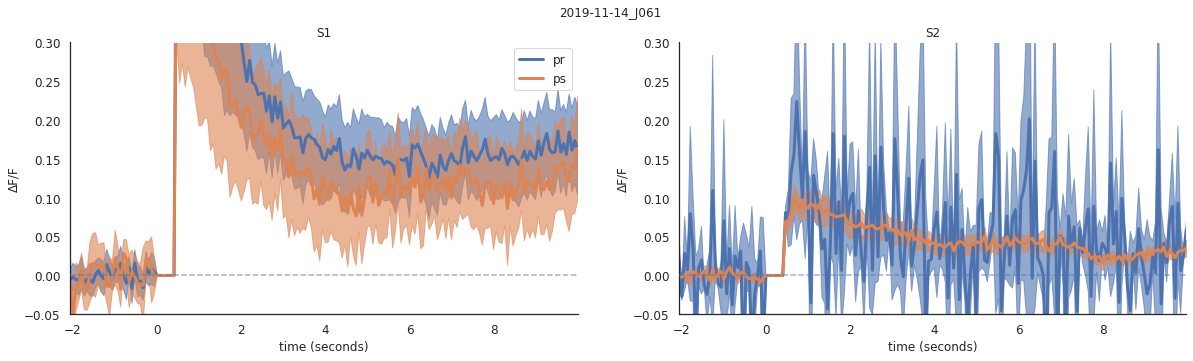

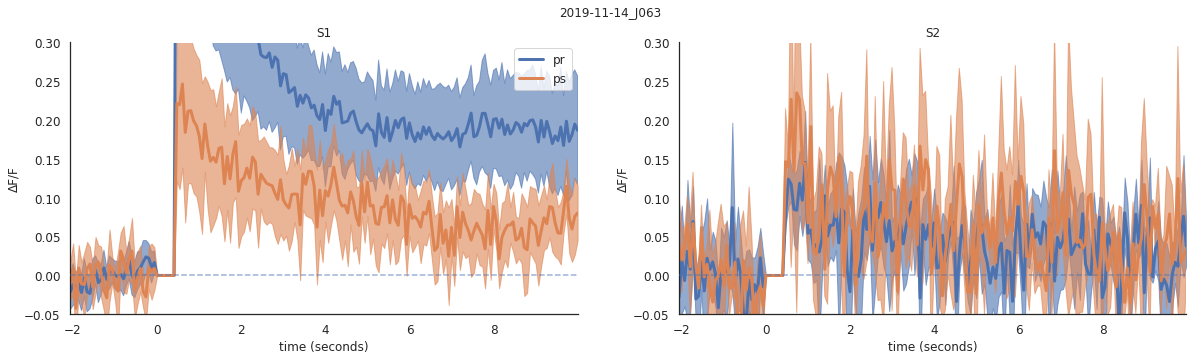

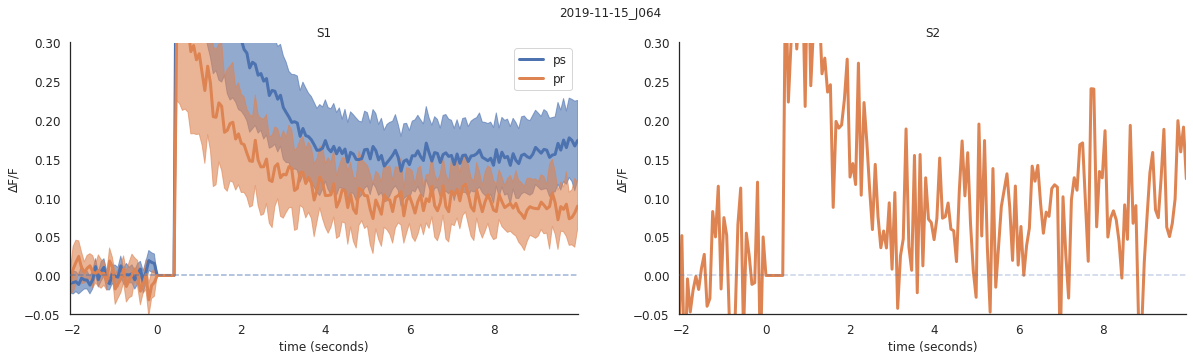

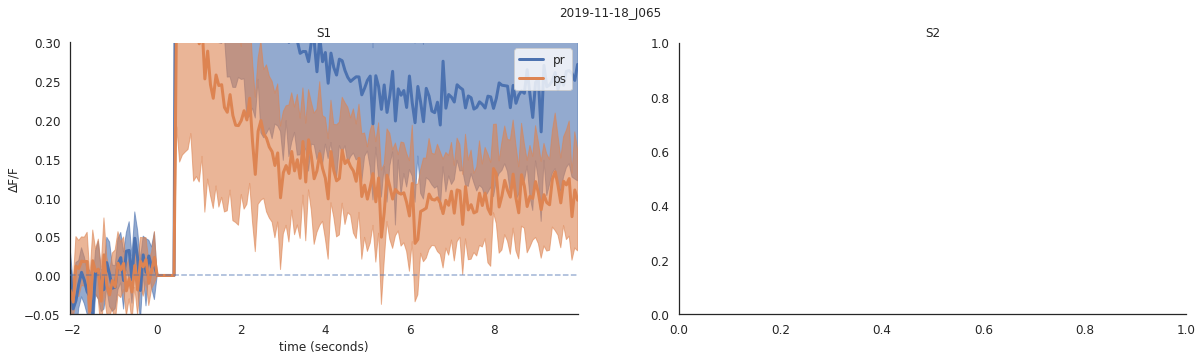

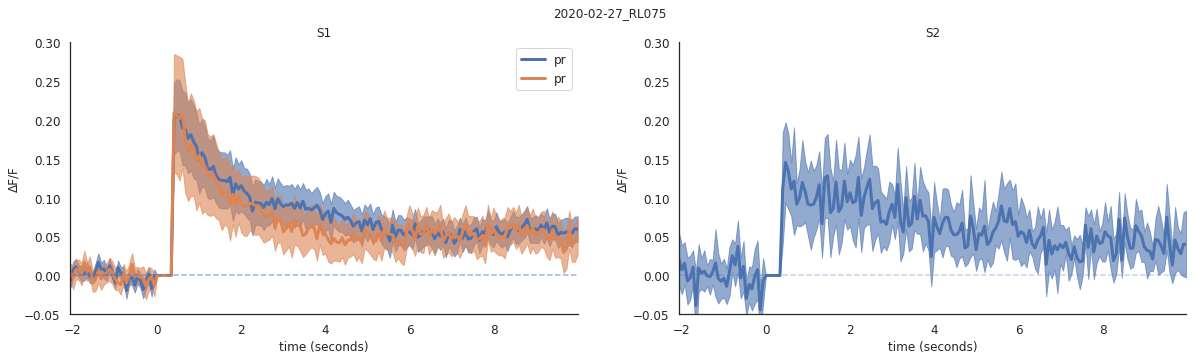

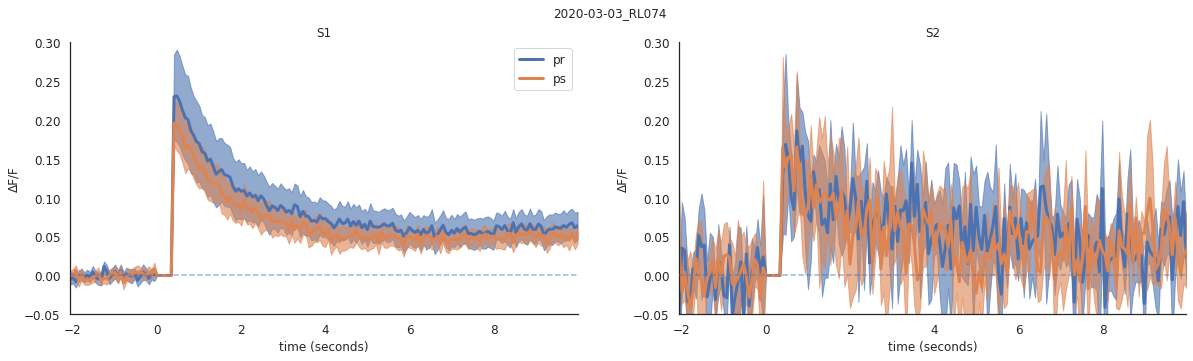

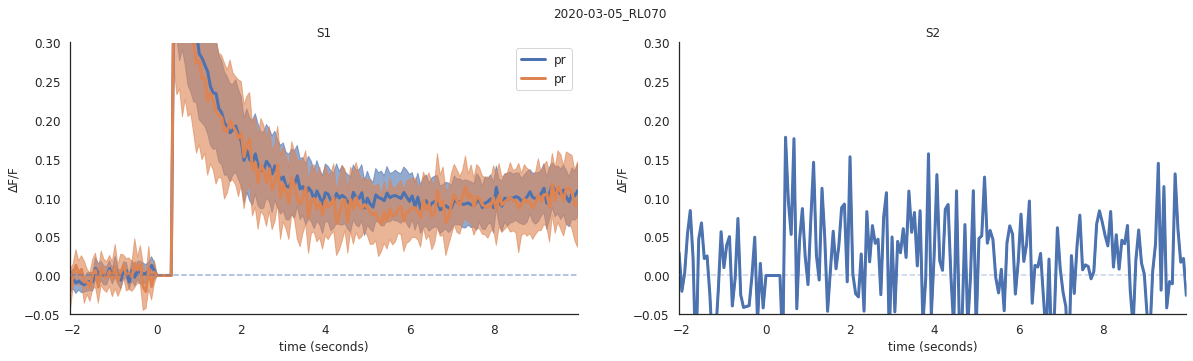

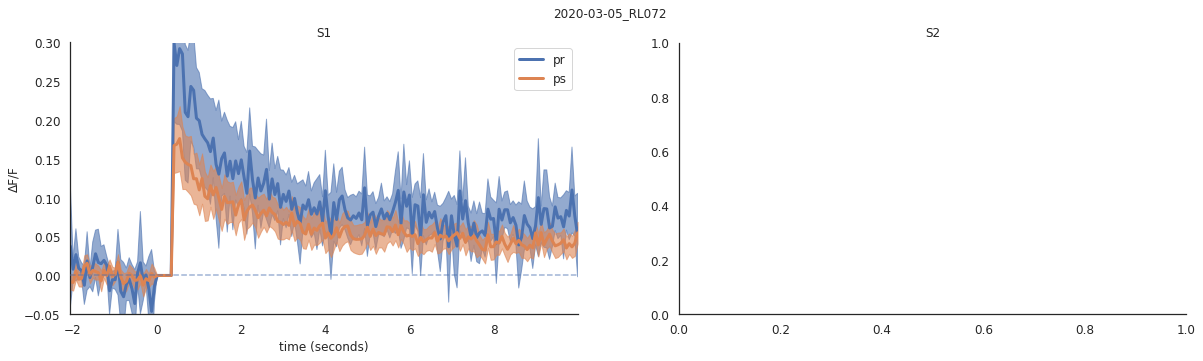

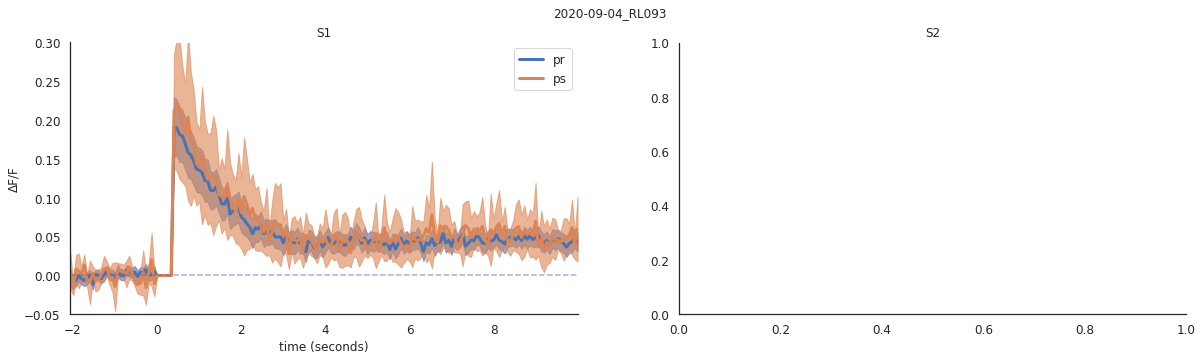

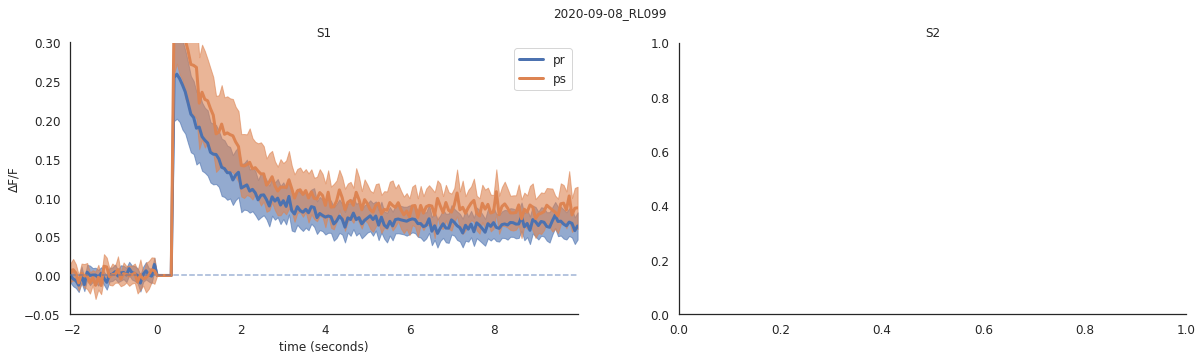

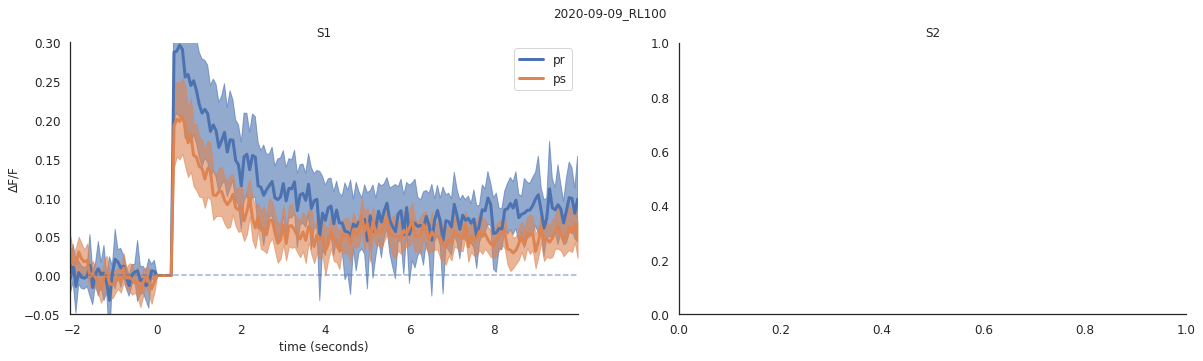

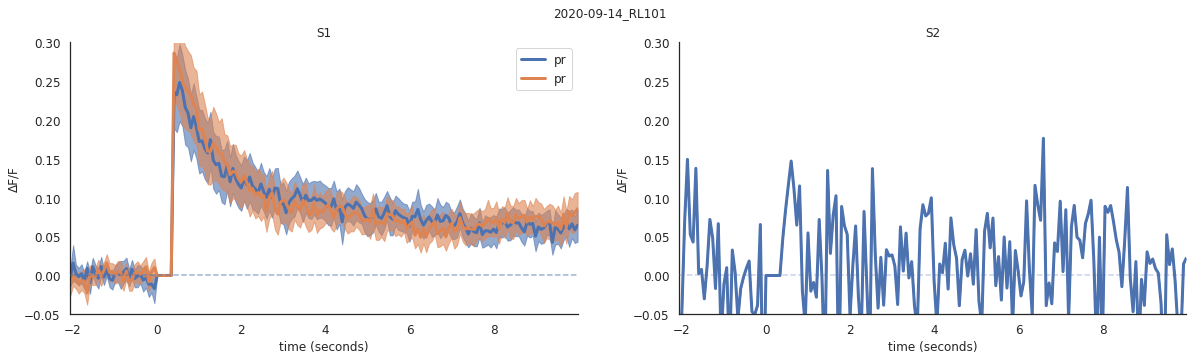

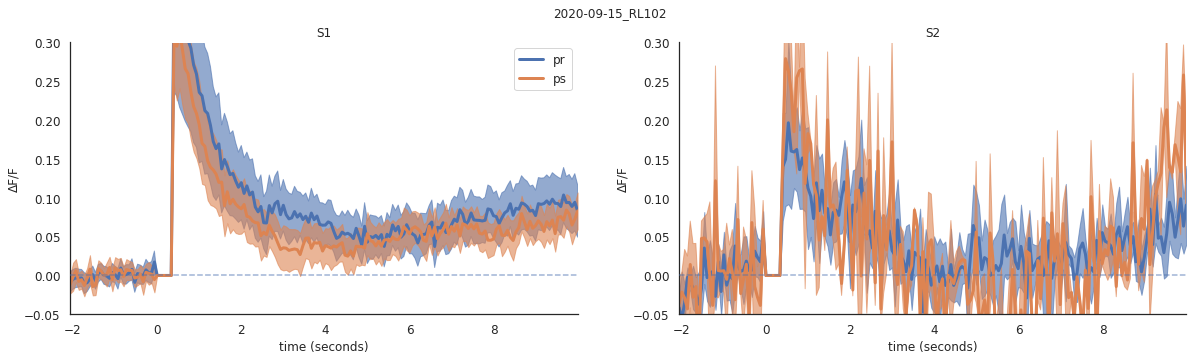

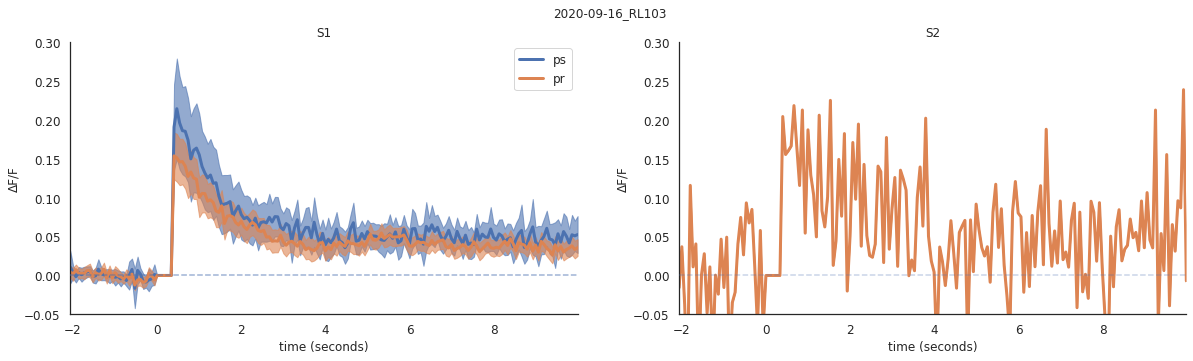

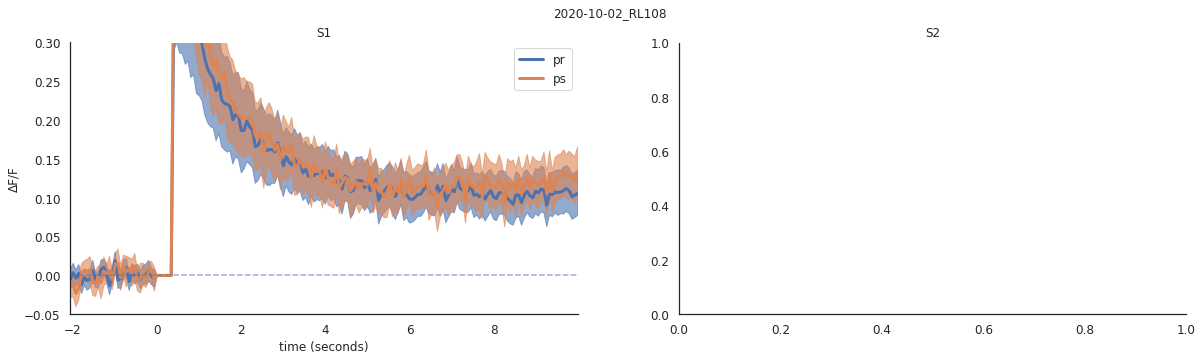

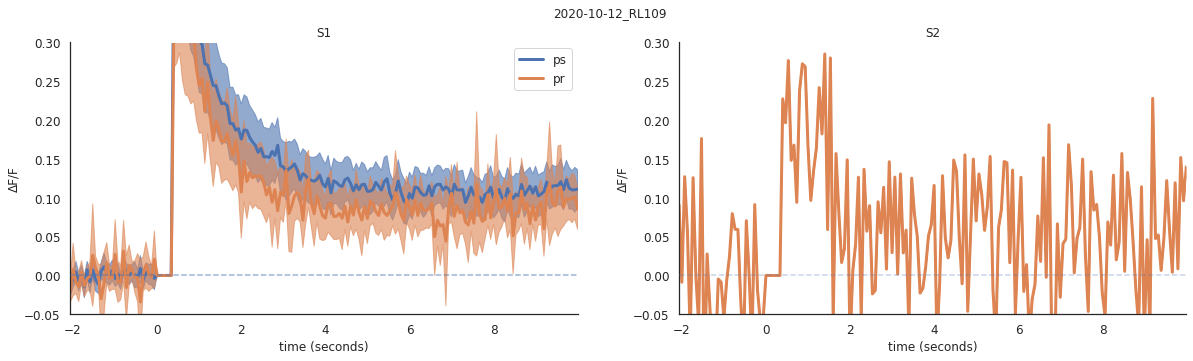

In [36]:
%matplotlib inline

pkl_files = os.listdir(pkl_folder)
pkl_files.sort()

threshold = 3

grand_average = []

for ses_i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        pkl_path = os.path.join(pkl_folder, pkl)
        print(pkl_path)

        with open(pkl_path, 'rb') as f:
            ses_obj = pickle.load(f)

        exp_list = [ses_obj.photostim_r, ses_obj.photostim_s]

#         if ses_obj.spont.n_frames > 0:
#             exp_list.append(ses_obj.spont)

#         if ses_obj.whisker_stim.n_frames > 0:
#             exp_list.append(ses_obj.whisker_stim)
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
        labels = []
        
        for i, ax_id in enumerate([1,0]):
            
            in_s1 = np.array(ses_obj.photostim_r.cell_s1[0])
            cell_ids = np.where(in_s1 == i)[0]
            
            plt.sca(ax[ax_id])
            plt.title('S' + str(ax_id+1))
            
            for exp_i, exp_obj in enumerate(exp_list):
                
                # for filtering sta significant cells with pos/neg amps
                cell_loc = np.where(in_s1 == i)
                sig_cells = np.where(exp_obj.sta_sig[0])
                amps = np.where(exp_obj.sta_amplitudes[0] > 0)
                cell_ids = np.intersect1d(cell_loc[0], sig_cells)
                cell_ids = np.intersect1d(cell_ids, amps)
                
                if cell_ids.shape[0] > 0: 
#                     masked_trials = maskTrials(exp_obj, filt='pos')
#                     cell_trials = plotExpAvgDffMasked(exp_obj, threshold, cell_ids, masked_trials)
                    
                    labels.append(exp_obj.stim_type)
                    cell_trials = plotExpAvgDff(exp_obj, threshold, cell_ids)
                    grand_average.append(cell_trials)
                
        fig.suptitle(exp_obj.sheet_name)
        plt.legend(labels[:len(exp_list)], loc='upper right')
#         plt.savefig(os.path.join(fig_save_path, 'trial_avg_dff_traces_detrended', ses_obj.sheet_name + '_grand_trial_avg_s1s2_detrend.png'))
#         plt.savefig(os.path.join(fig_save_path, 'trial_avg_dff_traces_detrended', ses_obj.sheet_name + '_grand_trial_avg_s1s2_detrend.svg'))

# save_path = os.path.join(fig_save_path, 'for_manuscript', 'RL072_avg_w_resp')
# plt.savefig(save_path + '.svg', bbox_inches='tight')

### Plot grand mean dF/F (pooled animals, cells and trials, separated trial type)

247 s1 cells
254 s2 cells


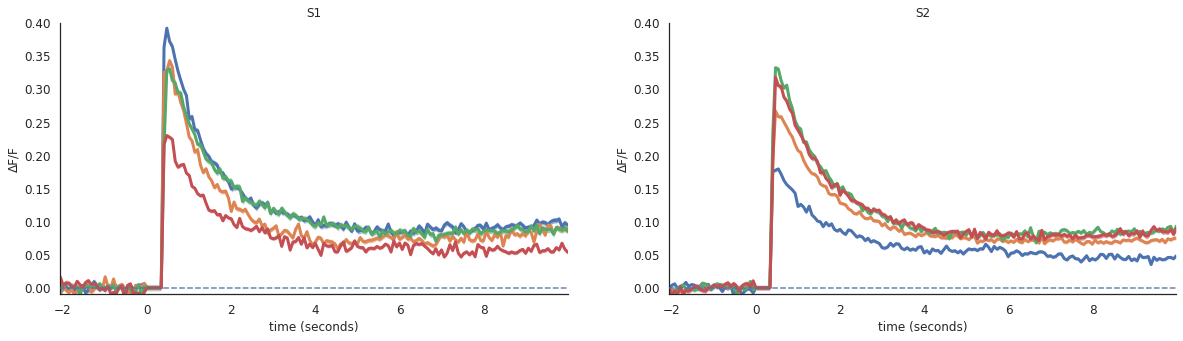

In [41]:
min_frames = np.inf
for avg in grand_average:
    curr_frames = np.size(avg, axis=1)
    if curr_frames < min_frames:
        min_frames = curr_frames
        
s2_pr = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[::8]]), axis=0)
s2_ps = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[1::8]]), axis=0)
s2_none = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[2::8]]), axis=0)
s2_w = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[3::8]]), axis=0)

s1_pr = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[4::8]]), axis=0)
s1_ps = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[5::8]]), axis=0)
s1_none = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[6::8]]), axis=0)
s1_w = np.concatenate(np.array([avg[:,:min_frames] for avg in grand_average[7::8]]), axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

plt.sca(ax[0])
plt.title('S1')

for trials in [s1_pr, s1_ps, s1_none, s1_w]:
    
    grand_mean = np.mean(trials, axis=0)
    grand_std = np.std(grand_mean, axis=0)
    grand_ci = 1.960 * (grand_std/np.sqrt(trials.shape[0]))
    grand_sem = grand_std/np.sqrt(trials.shape[0])

    fps = exp_obj.fps
    x = np.array(range( -exp_obj.pre_frames , exp_obj.post_frames ))/fps

    # find minimum and maximum x values (for plotting)
    x_max = np.max(x)
    x_min = np.min(x)

    #construct plot
    plt.plot(x, grand_mean, lw=3, zorder=2);
    plt.fill_between(x, grand_mean + grand_sem, grand_mean - grand_sem, alpha=0.6, zorder=1);
    plt.hlines(0, x_min, x_max, linestyles='dashed', zorder=4, alpha=0.3);
    plt.ylim([-0.01, 0.4]);
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('time (seconds)');
    plt.ylabel('ΔF/F');
    
plt.sca(ax[1])
plt.title('S2')

for trials in [s2_pr, s2_ps, s2_none, s2_w]:
    
    grand_mean = np.mean(trials, axis=0)
    grand_std = np.std(grand_mean, axis=0)
    grand_ci = 1.960 * (grand_std/np.sqrt(trials.shape[0]))
    grand_sem = grand_std/np.sqrt(trials.shape[0])

    fps = exp_obj.fps
    x = np.array(range( -exp_obj.pre_frames , exp_obj.post_frames ))/fps

    # find minimum and maximum x values (for plotting)
    x_max = np.max(x)
    x_min = np.min(x)

    #construct plot
    plt.plot(x, grand_mean, lw=3, zorder=2);
    plt.fill_between(x, grand_mean + grand_sem, grand_mean - grand_sem, alpha=0.6, zorder=1);
    plt.hlines(0, x_min, x_max, linestyles='dashed', zorder=4, alpha=0.3);
    plt.ylim([-0.01, 0.4]);
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('time (seconds)');
    plt.ylabel('ΔF/F');
    
print(s1_w.shape[0], 's1 cells')
print(s2_w.shape[0], 's2 cells')

# plt.savefig(os.path.join(fig_save_path, 'grand_avg_traces_detrended', 'grand_mean_sem_s1s2.png'))
# plt.savefig(os.path.join(fig_save_path, 'grand_avg_traces_detrended', 'grand_mean_sem_s1s2.svg'))

### Plot positive and negative amplitudes in space (pooled trial repeats, separated trial type, session and cell)

In [ ]:
pkl_files = os.listdir(pkl_folder)

all_amps = []
all_dists = []
all_x = []
all_y = []

for i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        pkl_path = os.path.join(pkl_folder, pkl)

        with open(pkl_path, 'rb') as f:
            ses_obj = pickle.load(f)
        
        exp_list = []
#         exp_list.append(ses_obj.photostim_r)
        exp_list.append(ses_obj.photostim_s)
        
#         if ses_obj.whisker_stim.n_frames > 0:
#             exp_list.append(ses_obj.whisker_stim)
            
#         if ses_obj.spont.n_frames > 0:
#             exp_list.append(ses_obj.spont)
        
        fig = plt.figure(figsize=(7*len(exp_list),5))
        fig.suptitle(pkl_path)
        
        for i,exp_obj in enumerate(exp_list):
            
            followers = []

            for cell in range(exp_obj.n_units[0]): # for all cells
#             for cell in np.where(exp_obj.sta_sig[0])[0]: # for responders
                cell_coord = exp_obj.cell_med[0][cell]
                
                if exp_obj.stim_type is 'w':
                    followers.append(([cell_coord[1],cell_coord[0]], exp_obj.sta_amplitudes[0][cell]))
                elif exp_obj.stim_type is 'none':
                    if ses_obj.photostim_r.targeted_cells[cell]==0:
                        followers.append(([cell_coord[1],cell_coord[0]], exp_obj.sta_amplitudes[0][cell]))
                else:
                    if exp_obj.targeted_cells[cell]==0:
                        followers.append(([cell_coord[1],cell_coord[0]], exp_obj.sta_amplitudes[0][cell]))
            
            # Work out nearest neighbour target
#             tree = spatial.KDTree(exp_obj.target_coords)

            norm_x = []
            norm_y = []
            amps = []
            dists = []

            for coord, amp in followers:
                # Distance from and index of nearest neighbour target
#                 dist, index = tree.query(coord)
#                 x,y = np.subtract(coord, exp_obj.target_coords[index])
#                 norm_x.append(x)
#                 norm_y.append(y)
#                 dists.append(dist)
                amps.append(amp)
                
                norm_x.append(coord[0])
                norm_y.append(coord[1])
                                
            x_um = [x*exp_obj.pix_sz_x for x in norm_x]
            y_um = [y*exp_obj.pix_sz_y for y in norm_y]
            ax = fig.add_subplot(1, len(exp_list), i+1)
            sc = ax.scatter(x_um, y_um, c=amps, cmap='RdBu_r', vmin=-0.1, vmax=0.1, alpha=0.5, linewidth=0)
            
            ax.set_aspect('equal')
            ax.set_xlabel('Cortical distance (um)')
            ax.set_ylabel('Cortical distance (um)')
            ax.set_title(exp_obj.stim_type)
            ax.set_ylim(ax.get_ylim()[::-1])
    
            all_amps.extend(amps)
            all_dists.extend(np.absolute(dists))
            all_x.extend(x_um)
            all_y.extend(y_um)
            
        cb = plt.colorbar(sc, ax=ax)
        cb.set_label('dF/F')
        plt.show();
        
#         fig.savefig(os.path.join(fig_save_path, 'spatial_responses', pkl[:-4] + '_pr_ps_w_spont_dFF_spatial.png'),
#                    bbox_inches='tight')
#         fig.savefig(os.path.join(fig_save_path, 'spatial_responses', pkl[:-4] + '_pr_ps_w_spont_dFF_spatial.svg'),
#                    bbox_inches='tight')

In [ ]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    
    return qx, qy

### Plot positive and negative amplitudes in space (pooled trial repeats, separated trial type, session and cell) aligned by S1 coordinates

In [ ]:
pkl_files = os.listdir(pkl_folder)

all_amps = []
all_dists = []
all_x = []
all_y = []

for i,pkl in enumerate(pkl_files):
    if '.pkl' in pkl:
        
        pkl_path = os.path.join(pkl_folder, pkl)

        with open(pkl_path, 'rb') as f:
            ses_obj = pickle.load(f)
        
        # Work out angle of rotation to apply to all cell coords
        s1_coord = np.array(ses_obj.s1_coord)
        s2_coord = np.array(ses_obj.s2_coord)
        s2_coord = s2_coord-s1_coord
        x = s2_coord[0]
        y = s2_coord[1]
        angle_rad = np.arctan2(y, x)
        rot_s2 = rotate([0,0], s2_coord, -angle_rad)
        
        exp_list = []
#         exp_list.append(ses_obj.photostim_r)
        exp_list.append(ses_obj.photostim_s)
        
#         if ses_obj.whisker_stim.n_frames > 0:
#             exp_list.append(ses_obj.whisker_stim)
            
#         if ses_obj.spont.n_frames > 0:
#             exp_list.append(ses_obj.spont)
        
        fig = plt.figure(figsize=(7*len(exp_list),5))
        fig.suptitle(pkl_path)
        
        for i,exp_obj in enumerate(exp_list):
            
            followers = []

#             for cell in range(exp_obj.n_units[0]): # for all cells
            for cell in np.where(exp_obj.sta_sig[0])[0]: # for responders
                cell_coord = np.array(exp_obj.cell_med[0][cell])
                # offset coord for s1 alignment
                transl_coord = cell_coord[::-1] - s1_coord
                # rotate coord for s2 alignment
                rot_coord = rotate([0,0], transl_coord, -angle_rad)
                
                if exp_obj.stim_type is 'w':
                    followers.append(([rot_coord[0],rot_coord[1]], exp_obj.sta_amplitudes[0][cell]))
                elif exp_obj.stim_type is 'none':
                    if ses_obj.photostim_r.targeted_cells[cell]==0:
                        followers.append(([rot_coord[0],rot_coord[1]], exp_obj.sta_amplitudes[0][cell]))
                else:
                    if exp_obj.targeted_cells[cell]==0:
                        followers.append(([rot_coord[0],rot_coord[1]], exp_obj.sta_amplitudes[0][cell]))
            
            # Work out nearest neighbour target
#             tree = spatial.KDTree(exp_obj.target_coords)

            norm_x = []
            norm_y = []
            amps = []
            dists = []

            for coord, amp in followers:
                # Distance from and index of nearest neighbour target
#                 dist, index = tree.query(coord)
#                 x,y = np.subtract(coord, exp_obj.target_coords[index])
#                 norm_x.append(x)
#                 norm_y.append(y)
#                 dists.append(dist)
                amps.append(amp)
                
                norm_x.append(coord[0])
                norm_y.append(coord[1])
                                
            x_um = [x*exp_obj.pix_sz_x for x in norm_x]
            y_um = [y*exp_obj.pix_sz_y for y in norm_y]
            ax = fig.add_subplot(1, len(exp_list), i+1)
            sc = ax.scatter(x_um, y_um, c=amps, cmap='RdBu_r', vmin=-0.1, vmax=0.1, alpha=0.5, linewidth=0)
            
            ax.set_aspect('equal')
            ax.set_xlabel('Cortical distance (um)')
            ax.set_ylabel('Cortical distance (um)')
            ax.set_title(exp_obj.stim_type)
            ax.set_ylim(ax.get_ylim()[::-1])
    
            all_amps.extend(amps)
            all_dists.extend(np.absolute(dists))
            all_x.extend(x_um)
            all_y.extend(y_um)
            
        cb = plt.colorbar(sc, ax=ax)
        cb.set_label('dF/F')
        plt.show();
        
#         fig.savefig(os.path.join(fig_save_path, 'spatial_responses', pkl[:-4] + '_pr_ps_w_spont_dFF_spatial.png'),
#                    bbox_inches='tight')
#         fig.savefig(os.path.join(fig_save_path, 'spatial_responses', pkl[:-4] + '_pr_ps_w_spont_dFF_spatial.svg'),
#                    bbox_inches='tight')

In [ ]:
# rotate all s2_coords

s1s2_coords = np.array(s1s2_coords)
s2_coords = s1s2_coords[:, 2:]
s1_coords = s1s2_coords[:, 0:2]

tf_s2_coords = s2_coords-s1_coords
rot_s2_coords = np.full_like(tf_s2_coords, np.nan)

for i, coord in enumerate(tf_s2_coords):
    x, y = coord
    angle_rad = np.arctan2(y, x)
    rot_coord = rotate([0,0], coord, -angle_rad)
    rot_s2_coords[i] = np.array(rot_coord)*ses_obj.photostim_r.pix_sz_x

In [ ]:
# save all_x, all_y, pos_x, pos_y, neg_x, neg_y
# use all coord for xedges/yedges and use that to make 2D histogram of pos/neg
# divide denominator from pos/neg by denominator from all
# result is % cells in that bin that responded, normalising for differences in density

bins = 20
total_cells, xedges, yedges = np.histogram2d(all_x, all_y, bins=bins)

In [ ]:
all_amps = np.array(all_amps)
all_x = np.array(all_x)
all_y = np.array(all_y)

pos_cells, neg_cells = np.where(np.array(all_amps) > 0), np.where(np.array(all_amps) < 0)

pos_x, pos_y = all_x[pos_cells], all_y[pos_cells]
neg_x, neg_y = all_x[neg_cells], all_y[neg_cells]

pos_cells, _, _ = np.histogram2d(pos_x, pos_y, bins=[xedges, yedges])
neg_cells, _, _ = np.histogram2d(neg_x, neg_y, bins=[xedges, yedges])

In [ ]:
pos_norm = (pos_cells/total_cells)*100

Y, X  = np.meshgrid(yedges, xedges)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=True, sharey=True)
mesh1 = ax[0].pcolormesh(X, Y, pos_cells, cmap='Reds', vmin=0, vmax=40)
ax[0].set_xlabel('Cortical distance (um)')
ax[0].set_ylabel('Cortical distance (um)')
ax[0].set_ylim([1000, -1000])
ax[0].set_aspect('equal')
ax[0].set_title('Binned responses (' + str(bins*bins) + ' bins)')
cb = plt.colorbar(mesh1, ax=ax[0])
cb.set_label('% cells')

ax[0].scatter(rot_s2_coords[:,0], rot_s2_coords[:,1], color='k')

neg_norm = (neg_cells/total_cells)*100

mesh2 = ax[1].pcolormesh(X, Y, neg_cells, cmap='Blues', vmin=0, vmax=45)
ax[1].set_xlabel('Cortical distance (um)')
ax[1].set_ylabel('Cortical distance (um)')
ax[0].set_ylim([1000, -1000])
ax[1].set_aspect('equal')
ax[1].set_title('Binned responses (' + str(bins*bins) + ' bins)')
cb = plt.colorbar(mesh2, ax=ax[1])
cb.set_label('% cells')

ax[1].scatter(rot_s2_coords[:,0], rot_s2_coords[:,1], color='k');

fig.savefig(os.path.join(fig_save_path, 'for_manuscript', 'spatial_numcells_ps_histogram_responders.svg'),
           bbox_inches='tight')

### Function for plotting average responses in space

In [ ]:
def binned_amplitudes_2d(all_x, all_y, all_amps):
    
    bins = 20
    all_amps_real = np.nan_to_num(all_amps)
    denominator, xedges, yedges = np.histogram2d(all_x, all_y, bins=bins)
    numerator, _, _ = np.histogram2d(all_x, all_y, bins=bins, weights=all_amps_real)
    h = numerator/denominator
    X, Y = np.meshgrid(xedges, yedges)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=True, sharey=True)
    mesh1 = ax[0].pcolormesh(X, Y, h, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
    ax[0].set_xlabel('Cortical distance (um)')
    ax[0].set_ylabel('Cortical distance (um)')
    ax[0].set_aspect('equal')
    ax[0].set_ylim([max(all_y), min(all_y)])
    ax[0].set_title('Binned responses (' + str(bins*bins) + ' bins)')
    cb = plt.colorbar(mesh1, ax=ax[0])
    cb.set_label('dF/F')

    mesh2 = ax[1].pcolormesh(X, Y, denominator.astype(int), cmap='inferno', vmin=0, vmax=np.amax(denominator))
    ax[1].set_xlabel('Cortical distance (um)')
    ax[1].set_ylabel('Cortical distance (um)')
    ax[1].set_aspect('equal')
    ax[1].set_ylim([max(all_y), min(all_y)])
    ax[1].set_title('Number of cells in bin')
    cb = plt.colorbar(mesh2, ax=ax[1])
    cb.set_label('num cells')

### Plot average response to stim, binned in 2D (pooled animal and trial repeats, separated trial types)

In [ ]:
stim = 'pr'

indices = [i for i,amp in enumerate(all_amps) if amp > 0]
x = [x for i,x in enumerate(all_x) if i in indices]
y = [y for i,y in enumerate(all_y) if i in indices]
pos_amps = [amp for i,amp in enumerate(all_amps) if i in indices]

binned_amplitudes_2d(x, y, pos_amps)
# plt.savefig(os.path.join(fig_save_path, 'for_manuscript', stim + '_dFF_spatial_pos_allcells.svg'))

indices = [i for i,amp in enumerate(all_amps) if amp < 0]
x = [x for i,x in enumerate(all_x) if i in indices]
y = [y for i,y in enumerate(all_y) if i in indices]
neg_amps = [amp for i,amp in enumerate(all_amps) if i in indices]

binned_amplitudes_2d(x, y, neg_amps)
# plt.savefig(os.path.join(fig_save_path, 'for_manuscript', stim + '_dFF_spatial_neg_allcells.svg'))

binned_amplitudes_2d(all_x, all_y, all_amps)
# plt.savefig(os.path.join(fig_save_path, 'for_manuscript', stim + '_dFF_spatial_sum_allcells.svg'))

In [ ]:
def twoDimKDE(x, y, cmap='greys', ax):

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymax, ymin)
    ax.set_aspect('equal')
    # Contourf plot
#     cfset = ax.contourf(xx, yy, f, cmap=cmap)
    # Contour plot
    cset = ax.contour(xx, yy, f, cmap=cmap)

In [ ]:
all_amps = np.array(all_amps)
all_x = np.array(all_x)
all_y = np.array(all_y)

pos_cells, neg_cells = np.where(np.array(all_amps) > 0), np.where(np.array(all_amps) < 0)

pos_x, pos_y = all_x[pos_cells], all_y[pos_cells]
neg_x, neg_y = all_x[neg_cells], all_y[neg_cells]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
twoDimKDE(pos_x, pos_y, cmap='Reds', ax=ax)
# fig.savefig(os.path.join(fig_save_path, 'for_manuscript', 'spatial_numcells_ps_pos_contour_responders.svg'),
#            bbox_inches='tight')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
twoDimKDE(neg_x, neg_y, cmap='Blues', ax=ax)
# fig.savefig(os.path.join(fig_save_path, 'for_manuscript', 'spatial_numcells_ps_neg_contour_responders.svg'),
#            bbox_inches='tight')

In [ ]:
plt.scatter(pos_x, pos_y, color='lightcoral', alpha=1, zorder=2);
# plt.scatter(neg_x, neg_y, color='lightsteelblue', alpha=1, zorder=1);
plt.ylim([1100, -400])
plt.axis('equal');

plt.savefig(os.path.join(fig_save_path, 'for_manuscript', 'spatial_location_ps_pos_scatter_responders.svg'),
           bbox_inches='tight')

### Plot all cells/responders in space with colour = amplitude of response

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
scatter = axes.scatter(all_x, all_y, c=all_amps, cmap='RdBu_r', vmin=-0.1, vmax=0.1, alpha=0.4)
axes.set_ylim([1100,-500])
axes.set_aspect('equal');
cb = plt.colorbar(scatter, ax=axes)
cb.set_label('dF/F')
fig.savefig(os.path.join(fig_save_path, 'for_manuscript', 'ps_dFF_spatial_responders_scatter_cb.svg'),
       bbox_inches='tight')

### Attempts to plot 3D data (positive - x,y - and amplitude - z) as surface plot or similar

In [ ]:
bins = 20
all_amps_real = np.nan_to_num(all_amps)
denominator, xedges, yedges = np.histogram2d(all_x, all_y, bins=bins)
numerator, _, _ = np.histogram2d(all_x, all_y, bins=bins, weights=all_amps_real)
h = numerator/denominator
X, Y = np.meshgrid(xedges, yedges)

X2 = np.tile((X[0][:-1] + np.diff(X[0])/2), X.shape[0]-1).reshape(X.shape[0]-1, X.shape[1]-1)
X2.shape

Y2 = np.repeat(Y[:-1,0] + np.diff(Y[:,0]/2), Y.shape[0]-1, axis=0).reshape(Y.shape[0]-1, Y.shape[1]-1)
Y2.shape

from mpl_toolkits.mplot3d import Axes3D

# sns.kdeplot(all_x, all_y, shade=True, shade_lowest=False, cbar=True);
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X2, Y2, h, 500, cmap='inferno');

### Count number of whisker responsive cells targeted by pr or ps stim

In [ ]:
pr_targ = ses_obj.photostim_r.targeted_cells
ps_targ = ses_obj.photostim_s.targeted_cells

pr_cells = np.where(pr_targ)[0]
ps_cells = np.where(ps_targ)[0]

w = np.array(ses_obj.whisker_stim.sta_sig[0])
s1_cells = np.array(ses_obj.whisker_stim.cell_s1[0])
w_sig = np.sum(w & s1_cells)
pr_w = np.sum(w[pr_cells])
ps_w = np.sum(w[ps_cells])

print('pickle:', pkl_path, 'w_resp:', w_sig, 'pr_w:', pr_w, 'ps_w:', ps_w)

### Play with whisker stim data

In [ ]:
# Calculate the number of cells that responded both to whisker stim and photostim

# a = np.where(ses_obj.whisker_stim.sta_sig[0])
# b = np.where(ses_obj.photostim_r.sta_sig[0])
# print(a,b)
# sum(1 for i in b[0] if i in a[0])

# Plot whisker stim trials where cells went over 200 dFF

plt.figure(figsize=(5,10))
sta_mean = []

for i, sta in enumerate(ses_obj.whisker_stim.stas[0]):
    if ses_obj.whisker_stim.sta_sig[0][i]:
        plt.plot(sta, alpha=0.2)
        sta_mean.append(sta)
    
        if ses_obj.whisker_stim.sta_amplitudes[0][i] > 200:
            print(ses_obj.whisker_stim.cell_id[0][i])
            
sta_mean = np.mean(sta_mean, axis=0)

plt.plot(sta_mean, 'k', linewidth=2);

plt.axis([0, 55, -10, 300]);

### Play with dataframes from master object

In [18]:
with open(master_path, 'rb') as f:
    master_obj = pickle.load(f)

df = master_obj.df
print(df.columns)

AttributeError: 'interarealPlotting' object has no attribute 'df'

In [ ]:
df.describe().transpose()